In [7]:
# Mount Google Drive
if 'google.colab' in str(get_ipython()):
    from google.colab import drive # import drive from Gogle colab
    root = '/content/drive'     # default location for the drive
    # print(root)                 # print content of ROOT (Optional)
    drive.mount(root)
else:
    print('Not running on CoLab')

Mounted at /content/drive


In [8]:
from pathlib import Path

if 'google.colab' in str(get_ipython()):
    # EDIT THE PROJECT PATH IF DIFFERENT WITH YOUR ONE
    project_path = Path(root) / 'MyDrive' / 'Colab Notebooks' / 'HDAT9910'
    # OPTIONAL - set working directory according to your google drive project path
    # import os
    # Change directory to the location defined in project_path
    # os.chdir(project_path)
else:
    project_path = Path()

In [23]:
# General library import
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix)
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix



### **Section 1: Load and Preprocess Dataset (`master_data.csv`)**

1. **Load Data**
   - Import the dataset (`master_data.csv`) and inspect its structure to verify column names and data types.


In [10]:
# Define file path for the dataset
file_path = project_path / 'master_data.csv'
data = pd.read_csv(file_path)

# Display basic dataset information
print("Dataset Information:")
print(data.info())

<ipython-input-10-114cd81a1588>:3: DtypeWarning: Columns (32,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375552 entries, 0 to 375551
Data columns (total 97 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   icustay_id              375552 non-null  int64  
 1   hadm_id.x               375552 non-null  int64  
 2   subject_id.x            375552 non-null  int64  
 3   row_id                  375552 non-null  int64  
 4   dob.x                   375552 non-null  object 
 5   admittime.x             317763 non-null  object 
 6   dischtime.x             317763 non-null  object 
 7   age_years               375552 non-null  int64  
 8   intime.x                375552 non-null  object 
 9   outtime.x               375550 non-null  object 
 10  los                     375550 non-null  float64
 11  hosp_deathtime          13072 non-null   object 
 12  icu_expire_flag         375552 non-null  int64  
 13  hospital_expire_flag.x  317763 non-null  float64
 14 

In [154]:
# Identify columns with `.x` and `.y` suffixes
x_columns = [col for col in data.columns if col.endswith('.x')]
y_columns = [col for col in data.columns if col.endswith('.y')]

# Ensure the corresponding columns match by removing the suffix
paired_columns = [(col, col.replace('.x', '.y')) for col in x_columns if col.replace('.x', '.y') in y_columns]

# Initialize lists to track mismatches
mismatched_columns = []
mismatch_counts = {}

# Process each pair of `.x` and `.y` columns
for x_col, y_col in paired_columns:
    # Compare the two columns
    is_equal = data[x_col] == data[y_col]
    is_na_x = data[x_col].isna()
    is_na_y = data[y_col].isna()

    # Count mismatches (where both are non-NA but values differ)
    mismatch_count = ((~is_na_x) & (~is_na_y) & (~is_equal)).sum()

    if mismatch_count > 0:
        mismatched_columns.append((x_col, y_col))
        mismatch_counts[f"{x_col} vs {y_col}"] = mismatch_count

    # Merge columns, prioritizing non-NA values
    data[x_col.replace('.x', '')] = data[x_col].combine_first(data[y_col])

    # Drop the original `.x` and `.y` columns
    data.drop(columns=[x_col, y_col], inplace=True)

# Display the results
if mismatched_columns:
    print("Mismatched columns and their counts:")
    for pair, count in mismatch_counts.items():
        print(f"{pair}: {count} mismatches")
else:
    print("All `.x` and `.y` column pairs matched or were merged without mismatches.")


<ipython-input-154-092fd978a017>:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  data[x_col.replace('.x', '')] = data[x_col].combine_first(data[y_col])
<ipython-input-154-092fd978a017>:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  data[x_col.replace('.x', '')] = data[x_col].combine_first(data[y_col])


Mismatched columns and their counts:
glucose.x vs glucose.y: 6911 mismatches


glucose.x and glucose.y has so many mismatches because one form vitals_hourly table (Bedside measurement) and the other from labs_hourly table (Lab blood test results). It is reasonable that the values cannot be exactly the same. So I want to see the difference value of these 6911 mismatches and the percentage of these difference in averave value.

In [155]:
# Verify the available columns in the DataFrame
print(data.columns)

# Focus on the glucose column (merged)
glucose = data['glucose']

# Check exist
if 'glucose' in data.columns:
    print("Merged glucose column exists. Proceeding with analysis.")
    # Perform further analysis if needed
else:
    print("Merged glucose column not found. Review the merging process.")



Index(['icustay_id', 'row_id', 'age_years', 'los', 'hosp_deathtime',
       'icu_expire_flag', 'dod', 'ttd_days', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'admission_type', 'admission_location',
       'deathtime', 'icd9_code', 'intime_weekdays', 'is_weekend_admission',
       'gender', 'avg_weight_naive', 'MDROs', 'hr', 'starttime', 'endtime',
       'dy', 'spo2', 'fio2', 'temperature', 'resprate', 'heartrate', 'sysbp',
       'diasbp', 'meanarterialpressure', 'neutrophil', 'creactiveprotein',
       'whitebloodcell', 'partialpressureo2', 'bicarbonate', 'lactate',
       'troponin', 'bloodureanitrogen', 'creatinine', 'alaninetransaminase',
       'aspartatetransaminase', 'hemoglobin', 'intnormalisedratio',
       'platelets', 'albumin', 'chloride', 'sodium', 'bilirubin', 'hematocrit',
       'gcs', 'gcseyes', 'gcsmotor', 'gcsverbal', 'endotrachflag',
       'urineoutput', 'ethnic

In [156]:
# Save the processed dataset as 'processed_master_data.csv'
processed_file_path = project_path / 'processed_master_data.csv'
data.to_csv(processed_file_path, index=False)

print(f"Processed dataset saved as: {processed_file_path}")


Processed dataset saved as: /content/drive/MyDrive/Colab Notebooks/HDAT9910/processed_master_data.csv


In [157]:
# Define file path for the new processed dataset
file_path = project_path / 'processed_master_data.csv'

# Reload the processed dataset
data = pd.read_csv(file_path)

# Display basic dataset information
print("Dataset Information:")
print(data.info())

<ipython-input-157-6bff5113a6d1>:5: DtypeWarning: Columns (20,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375552 entries, 0 to 375551
Data columns (total 87 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   icustay_id             375552 non-null  int64  
 1   row_id                 375552 non-null  int64  
 2   age_years              375552 non-null  int64  
 3   los                    375550 non-null  float64
 4   hosp_deathtime         13072 non-null   object 
 5   icu_expire_flag        375552 non-null  int64  
 6   dod                    144359 non-null  object 
 7   ttd_days               144359 non-null  float64
 8   first_careunit         375552 non-null  object 
 9   last_careunit          375552 non-null  object 
 10  first_wardid           375552 non-null  int64  
 11  last_wardid            375552 non-null  int64  
 12  insurance              375552 non-null  object 
 13  language               235009 non-null  object 
 14  religion       

In [158]:
# Calculate missing data percentages
missing_percentages = data.isnull().mean() * 100

# Define the categories
columns_missing_25_or_less = missing_percentages[missing_percentages <= 25].index
columns_missing_25_to_75 = missing_percentages[(missing_percentages > 25) & (missing_percentages <= 75)].index
columns_missing_greater_than_75 = missing_percentages[missing_percentages > 75].index

# Display the lists
print("\nColumns with missing percentages ≤ 25%:")
print(list(columns_missing_25_or_less))

print("\nColumns with 25% < missing percentages ≤ 75%:")
print(list(columns_missing_25_to_75))

print("\nColumns with missing percentages > 75%:")
print(list(columns_missing_greater_than_75))



Columns with missing percentages ≤ 25%:
['icustay_id', 'row_id', 'age_years', 'los', 'icu_expire_flag', 'first_careunit', 'last_careunit', 'first_wardid', 'last_wardid', 'insurance', 'religion', 'marital_status', 'ethnicity', 'admission_type', 'admission_location', 'icd9_code', 'intime_weekdays', 'is_weekend_admission', 'gender', 'avg_weight_naive', 'MDROs', 'hr', 'starttime', 'endtime', 'dy', 'spo2', 'resprate', 'heartrate', 'sysbp', 'diasbp', 'meanarterialpressure', 'ethnicity_group', 'heartrate_normal', 'heartrate_high', 'heartrate_low', 'spo2_normal', 'spo2_low', 'sysbp_normal', 'sysbp_high', 'sysbp_low', 'hadm_id', 'subject_id', 'dob', 'admittime', 'dischtime', 'intime', 'outtime', 'hospital_expire_flag', 'expire_flag']

Columns with 25% < missing percentages ≤ 75%:
['dod', 'ttd_days', 'language', 'temperature', 'gcs', 'gcseyes', 'gcsmotor', 'gcsverbal', 'endotrachflag', 'urineoutput', 'gcs_normal', 'gcs_low', 'glucose']

Columns with missing percentages > 75%:
['hosp_deathtime',

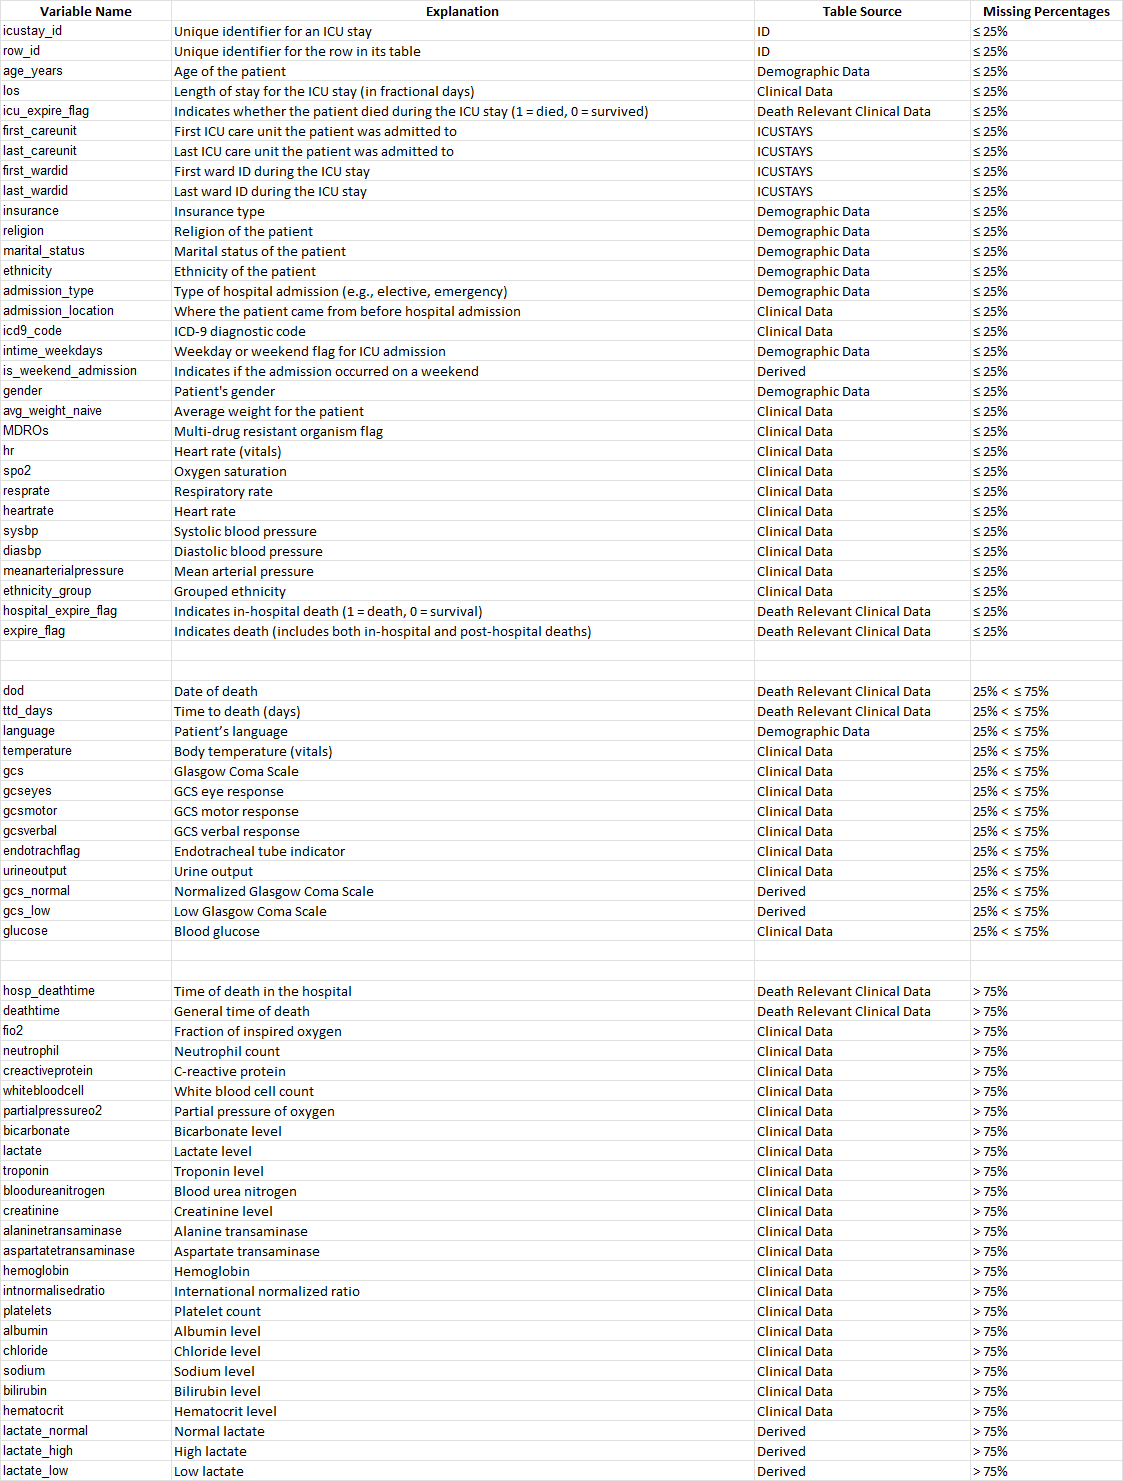

#### **1. Set `expire_flag` to 100% for Aim 1**
- **Rationale**:
  - Since the `expire_flag` column is your target variable for predicting mortality, rows with missing values in this column are not usable. Removing rows with missing `expire_flag` values ensures a clean dataset for modeling.

In [159]:
# Remove rows with missing expire_flag (Aim 1)
data_aim1 = data.dropna(subset=['expire_flag'])
print(f"Dataset for Aim 1: {data_aim1.shape}")


Dataset for Aim 1: (375552, 87)


#### **2. Set `intime_weekdays` and `is_weekend_admission` to 100% for Aim 2**
- **Rationale**:
  - These columns are critical for determining the admission timing (weekend vs. weekday). Ensuring no missing values will strengthen the analysis for the second aim.
- **Action**:
  - Remove rows with missing values in either `intime_weekdays` or `is_weekend_admission`.

In [160]:
# Remove rows with missing intime_weekdays or is_weekend_admission (Aim 2)
data_aim2 = data.dropna(subset=['intime_weekdays', 'is_weekend_admission'])
print(f"Dataset for Aim 2: {data_aim2.shape}")


Dataset for Aim 2: (375552, 87)


emoving all **Death Relevant Clinical Data** at the beginning for all analyses is a sound strategy
1. **Avoid Data Leakage**:
   Including variables that directly indicate or are derived from the outcome (e.g., `icu_expire_flag`, `deathtime`, `ttd_days`) may lead to overly optimistic models that simply rely on this "leaked" information.

2. **Focus on Predictive Features**:
   This approach ensures that the model learns patterns from other features (e.g., demographic data, clinical observations) that might have predictive power, rather than being overly reliant on data explicitly linked to mortality.

In [161]:
# Death Relevant Clinical Data
death_relevant_columns = [
    'icu_expire_flag', 'hospital_expire_flag',
    'hosp_deathtime', 'deathtime', 'dod', 'ttd_days'
]

# Remove Death Relevant Clinical Data from data_aim1
data_aim1 = data_aim1.drop(columns=death_relevant_columns, errors='ignore')
print(f"Dataset for Aim 1 after removing Death Relevant Clinical Data: {data_aim1.shape}")

# Remove Death Relevant Clinical Data from data_aim2
data_aim2 = data_aim2.drop(columns=death_relevant_columns, errors='ignore')
print(f"Dataset for Aim 2 after removing Death Relevant Clinical Data: {data_aim2.shape}")

Dataset for Aim 1 after removing Death Relevant Clinical Data: (375552, 81)
Dataset for Aim 2 after removing Death Relevant Clinical Data: (375552, 81)


In [162]:
# Save processed dataset for analysis
processed_file_path = project_path / 'data_aim1.csv'
data_aim1.to_csv(processed_file_path, index=False)

print("data_aim1.csv saved successfully!")

processed_file_path = project_path / 'data_aim2.csv'
data_aim2.to_csv(processed_file_path, index=False)

print("data_aim2.csv saved successfully!")

data_aim1.csv saved successfully!
data_aim2.csv saved successfully!


#### **3. Two Dataset Process Styles**

- **Style A**: Drop columns with >25% missing values and impute remaining missing values (≤25%).
  - **Advantages**: Larger dataset, faster processing, minimal bias.
  - **Disadvantages**: Loss of columns with potentially valuable clinical data.
- **Style B**: Retain more clinical data by finding rows with enough information for columns >25% missing. Then impute missing values for the rest.
  - **Advantages**: Includes more clinical data for analysis.
  - **Disadvantages**: Smaller dataset, potential introduction of bias due to selective row retention.

In [163]:
# Drop columns with >25% missing
missing_percentages = data_aim1.isnull().mean() * 100
columns_to_drop = missing_percentages[missing_percentages > 25].index
data_style_a = data_aim1.drop(columns=columns_to_drop)

# Identify numeric columns for imputation
numeric_columns_to_impute = data_style_a.select_dtypes(include=['float64', 'int64']).columns.intersection(
    missing_percentages[missing_percentages <= 25].index
)

# Impute missing values for numeric columns
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
data_style_a[numeric_columns_to_impute] = imputer.fit_transform(data_style_a[numeric_columns_to_impute])

print(f"Dataset Style A after dropping columns >25% missing and imputing numeric values: {data_style_a.shape}")


Dataset Style A after dropping columns >25% missing and imputing numeric values: (375552, 47)


In [164]:
# Save processed dataset for analysis
processed_file_path = project_path / 'data_style_a.csv'
data_style_a.to_csv(processed_file_path, index=False)

print("data_style_a.csv saved successfully!")

data_style_a.csv saved successfully!


In [165]:
# Define threshold for "enough data" (e.g., ≥75% of columns must have non-NaN values)
threshold = int(0.75 * data_aim1.shape[1])

# Filter rows with enough data and make a copy to avoid SettingWithCopyWarning
data_style_b = data_aim1.dropna(thresh=threshold).copy()
print(f"Dataset Style B after filtering rows with enough data: {data_style_b.shape}")

# Separate columns by data type
numeric_columns = data_style_b.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = data_style_b.select_dtypes(include=['object', 'category']).columns
boolean_columns = data_style_b.select_dtypes(include=['bool']).columns

# Impute numeric columns with mean
numeric_imputer = SimpleImputer(strategy='mean')
data_style_b.loc[:, numeric_columns] = pd.DataFrame(
    numeric_imputer.fit_transform(data_style_b[numeric_columns]),
    columns=numeric_columns,
    index=data_style_b.index
)

# Impute categorical columns with the most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
data_style_b.loc[:, categorical_columns] = pd.DataFrame(
    categorical_imputer.fit_transform(data_style_b[categorical_columns]),
    columns=categorical_columns,
    index=data_style_b.index
)

# Handle boolean columns
# Step 1: Convert boolean columns to integers and store temporarily
boolean_data_as_int = data_style_b[boolean_columns].astype('int')

# Step 2: Impute missing values for boolean columns (as integers)
boolean_imputed = pd.DataFrame(
    SimpleImputer(strategy='most_frequent').fit_transform(boolean_data_as_int),
    columns=boolean_columns,
    index=data_style_b.index
)

# Step 3: Convert back to boolean and assign to the dataframe
data_style_b.loc[:, boolean_columns] = boolean_imputed.astype('bool')

# Confirm the shape of the dataset after imputation
print(f"Dataset Style B after imputing missing values: {data_style_b.shape}")



Dataset Style B after filtering rows with enough data: (21586, 81)
Dataset Style B after imputing missing values: (21586, 81)


SimpleImputer doesn't support boolean (bool) data types directly. To address this, need to explicitly convert boolean columns to a format compatible with SimpleImputer, such as integer or string representation, before applying imputation.

Temporary Storage for Boolean Columns:
- Boolean columns are converted to integers and stored in boolean_data_as_int before imputation.
- After imputation, the imputed data is explicitly converted back to boolean before reassignment to the dataframe.

Reassign:
- Use pd.DataFrame() to explicitly reassign transformed data with the same columns and index.
- Use .astype('int') for compatibility with SimpleImputer.
Explicit Casting After Imputation:
- After imputation, explicitly cast the imputed columns back to bool using .astype('bool').
- Avoiding direct eeassignments
  - Direct reassignments to data_style_b.loc[:, boolean_columns] are handled via temporary variables to ensure compatibility and avoid the warnings.

In [166]:
# Save processed dataset for analysis
processed_file_path = project_path / 'data_style_b.csv'
data_style_b.to_csv(processed_file_path, index=False)

print("data_style_b.csv saved successfully!")


data_style_b.csv saved successfully!


2. **Split Data**
   - Split the dataset into training (80%) and validation (20%) sets.
   - Use stratified splitting based on the target variable `expire_flag` (1 indicates death , and 0 indicates survival) to maintain the class distribution.
   - Ensure reproducibility with a random seed.

3. **Feature Preprocessing**
  - Apply preprocessing steps **after splitting**:
    - Fit the `StandardScaler` only on the training features (`X_train`).
    - Apply the fitted scaler to transform both `X_train` and `X_val`.
  - Use pipelines for consistent and reusable preprocessing across models.

Step 1: Define File Paths and Reload Datasets

In [167]:
# Define file path for the new processed dataset
style_a_path = project_path / 'data_style_a.csv'
style_b_path = project_path / 'data_style_b.csv'

# Reload the processed dataset
data_style_a = pd.read_csv(style_a_path)
data_style_b = pd.read_csv(style_b_path)

print(f"Dataset Style A: {data_style_a.shape}")
print(f"Dataset Style B: {data_style_b.shape}")

<ipython-input-167-d6afadbcdec2>:6: DtypeWarning: Columns (14,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  data_style_a = pd.read_csv(style_a_path)


Dataset Style A: (375552, 47)
Dataset Style B: (21586, 81)


Step 2: Define Features and Target, and Process Datasets
Repeat the analysis separately for both datasets.

For data_style_a:

In [168]:
# Define features (X) and target (y) for Style A
target_column = 'expire_flag'  # Mortality outcome
X_a = data_style_a.drop(columns=[target_column])  # Features
y_a = data_style_a[target_column]  # Target

# Split the data into training and validation sets
X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(
    X_a, y_a,
    test_size=0.2,  # 20% validation
    stratify=y_a,   # Stratified splitting to maintain class balance
    random_state=42 # Ensure reproducibility
)

# Confirm class distribution in each split
print("\nStyle A - Training set distribution:\n", y_train_a.value_counts(normalize=True))
print("\nStyle A - Validation set distribution:\n", y_val_a.value_counts(normalize=True))

# Identify numerical columns
numerical_columns_a = X_train_a.select_dtypes(include=['float64', 'int64']).columns

# Preprocessing pipeline
scaler_a = StandardScaler()
pipeline_a = Pipeline([
    ('scaler', scaler_a)  # Add additional steps here if needed
])

# Scale the numerical features for Style A
X_train_scaled_a = pipeline_a.fit_transform(X_train_a[numerical_columns_a])  # Fit and transform training data
X_val_scaled_a = pipeline_a.transform(X_val_a[numerical_columns_a])          # Transform validation data

# Display scaled feature statistics for Style A
print("\nStyle A - Training data after scaling (first 5 rows):")
print(pd.DataFrame(X_train_scaled_a, columns=numerical_columns_a).head())



Style A - Training set distribution:
 expire_flag
0.0    0.615608
1.0    0.384392
Name: proportion, dtype: float64

Style A - Validation set distribution:
 expire_flag
0.0    0.615609
1.0    0.384391
Name: proportion, dtype: float64

Style A - Training data after scaling (first 5 rows):
   icustay_id    row_id  age_years       los  first_wardid  last_wardid  \
0   -1.074328  0.142663  -2.093429 -0.242963      1.159523     1.183362   
1    1.044522  0.830813  -0.179621  0.230275      0.225273     0.240253   
2    0.274958 -0.846269   0.896896 -0.537762      1.269435     1.294316   
3    0.007539  1.248393   0.239024  0.116263     -1.203580    -1.202149   
4    1.031092  0.591452  -0.000202 -0.545315      0.225273     0.240253   

   avg_weight_naive        hr        dy      spo2  ...  heartrate_normal  \
0         -0.000458  0.111425 -0.199953  0.127592  ...          0.337955   
1         -0.291565 -1.537378 -0.199953  0.127592  ...          0.337955   
2         -0.767833 -1.087705 -0

For data_style_b:



In [169]:
# Define features (X) and target (y) for Style B
X_b = data_style_b.drop(columns=[target_column])  # Features
y_b = data_style_b[target_column]  # Target

# Split the data into training and validation sets
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(
    X_b, y_b,
    test_size=0.2,  # 20% validation
    stratify=y_b,   # Stratified splitting to maintain class balance
    random_state=42 # Ensure reproducibility
)

# Confirm class distribution in each split
print("\nStyle B - Training set distribution:\n", y_train_b.value_counts(normalize=True))
print("\nStyle B - Validation set distribution:\n", y_val_b.value_counts(normalize=True))

# Identify numerical columns
numerical_columns_b = X_train_b.select_dtypes(include=['float64', 'int64']).columns

# Preprocessing pipeline
scaler_b = StandardScaler()
pipeline_b = Pipeline([
    ('scaler', scaler_b)  # Add additional steps here if needed
])

# Scale the numerical features for Style B
X_train_scaled_b = pipeline_b.fit_transform(X_train_b[numerical_columns_b])  # Fit and transform training data
X_val_scaled_b = pipeline_b.transform(X_val_b[numerical_columns_b])          # Transform validation data

# Display scaled feature statistics for Style B
print("\nStyle B - Training data after scaling (first 5 rows):")
print(pd.DataFrame(X_train_scaled_b, columns=numerical_columns_b).head())



Style B - Training set distribution:
 expire_flag
0    0.598043
1    0.401957
Name: proportion, dtype: float64

Style B - Validation set distribution:
 expire_flag
0    0.597962
1    0.402038
Name: proportion, dtype: float64

Style B - Training data after scaling (first 5 rows):
   icustay_id    row_id  age_years       los  first_wardid  last_wardid  \
0    0.952425 -1.810647   0.057991 -0.607441     -0.753552    -0.746930   
1   -0.683166  0.439814   0.536612 -0.499151      0.258801     0.278868   
2    1.591635 -1.421828   0.297302 -0.216117     -0.753552    -0.746930   
3    1.258844  0.529300   1.314371 -0.475414      0.258801     0.278868   
4    0.799588 -0.725918   0.476785 -0.503920     -0.303617    -0.291020   

   avg_weight_naive        hr        dy      spo2  ...  spo2_normal  spo2_low  \
0          0.000497 -1.052143 -0.151411  0.619267  ...     0.214713 -0.214713   
1          0.496519 -1.357515 -0.151411  0.619267  ...     0.214713 -0.214713   
2          0.221507  0.32

### **Section 2: Model Implementation and Results Visualization**


#### **2.1 Logistic Regression**
1. **Baseline Implementation**
   - Train a logistic regression model using default settings.
   - Evaluate on the validation set using metrics: accuracy, precision, recall, F1-score, and ROC-AUC.

Baseline Logistic Regression for data_style_a

Classification Report for Style A:
              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78     46239
         1.0       0.65      0.51      0.58     28872

    accuracy                           0.71     75111
   macro avg       0.69      0.67      0.68     75111
weighted avg       0.70      0.71      0.70     75111

ROC-AUC Score for Style A: 0.7534614479777928


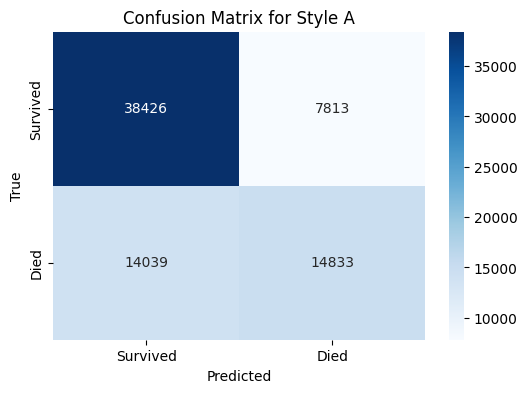

In [170]:
# Train logistic regression model for Style A
logreg_a = LogisticRegression(random_state=42, max_iter=1000)
logreg_a.fit(X_train_scaled_a, y_train_a)

# Make predictions on validation set for Style A
y_pred_a = logreg_a.predict(X_val_scaled_a)
y_pred_proba_a = logreg_a.predict_proba(X_val_scaled_a)[:, 1]

# Evaluate performance for Style A
print("Classification Report for Style A:")
print(classification_report(y_val_a, y_pred_a))

roc_auc_a = roc_auc_score(y_val_a, y_pred_proba_a)
print(f"ROC-AUC Score for Style A: {roc_auc_a}")

# Plot confusion matrix for Style A
conf_matrix_a = confusion_matrix(y_val_a, y_pred_a)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_a, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Style A')
plt.show()


- **Accuracy**: 0.71  
- **ROC-AUC**: 0.75  
- **Precision and Recall**:  
  - Class `0` (Survived): High recall (0.83), indicating fewer false negatives.  
  - Class `1` (Died): Moderate precision (0.65) and lower recall (0.51), suggesting more false negatives compared to false positives.  
- **Confusion Matrix**:  
  - High true positives and true negatives but noticeable misclassifications, especially for class `1` (14,039 false negatives).

Baseline Logistic Regression for data_style_b

Classification Report for Style B:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      2582
           1       0.68      0.57      0.62      1736

    accuracy                           0.72      4318
   macro avg       0.71      0.70      0.70      4318
weighted avg       0.72      0.72      0.72      4318

ROC-AUC Score for Style B: 0.7851179470063931


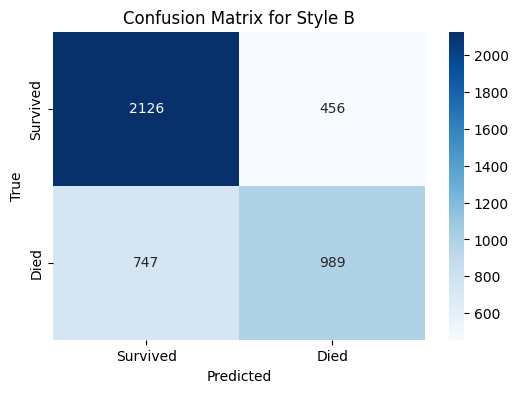

In [171]:
# Train logistic regression model for Style B
logreg_b = LogisticRegression(random_state=42, max_iter=1000)
logreg_b.fit(X_train_scaled_b, y_train_b)

# Make predictions on validation set for Style B
y_pred_b = logreg_b.predict(X_val_scaled_b)
y_pred_proba_b = logreg_b.predict_proba(X_val_scaled_b)[:, 1]

# Evaluate performance for Style B
print("Classification Report for Style B:")
print(classification_report(y_val_b, y_pred_b))

roc_auc_b = roc_auc_score(y_val_b, y_pred_proba_b)
print(f"ROC-AUC Score for Style B: {roc_auc_b}")

# Plot confusion matrix for Style B
conf_matrix_b = confusion_matrix(y_val_b, y_pred_b)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_b, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Style B')
plt.show()


- **Accuracy**: 0.72  
- **ROC-AUC**: 0.79  
- **Precision and Recall**:  
  - Class `0` (Survived): High recall (0.82), indicating fewer false negatives.  
  - Class `1` (Died): Balanced precision (0.68) and recall (0.57), with fewer false negatives compared to Style A.  
- **Confusion Matrix**:  
  - Fewer false negatives (747) for class `1`, though some misclassifications persist.

2. **Hyperparameter Tuning**
   - Use `GridSearchCV` to optimize regularization strength (`C`) with stratified K-fold cross-validation.
    - Logistic regression's regularization strength (C) plays a critical role in balancing underfitting and overfitting.
    - Optimizing C can improve precision, recall, and the ROC-AUC score, which are crucial for the medical context of predicting mortality.

   - Evaluate the best model and compare its performance to the baseline.

For Style A

In [172]:
# Define parameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Initialize logistic regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)

# GridSearchCV with stratified K-fold cross-validation
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,  # 5-fold stratified cross-validation
    n_jobs=-1  # Use all processors
)

# Fit GridSearchCV
grid_search.fit(X_train_scaled_a, y_train_a)

# Best parameter
print(f"Best Regularization Strength (C): {grid_search.best_params_['C']}")

# Evaluate the best model on the validation set
best_logreg = grid_search.best_estimator_
y_pred_a_tuned = best_logreg.predict(X_val_scaled_a)
y_pred_proba_a_tuned = best_logreg.predict_proba(X_val_scaled_a)[:, 1]

# Metrics
print("\nTuned Classification Report (Style A):")
print(classification_report(y_val_a, y_pred_a_tuned))
print("Tuned ROC-AUC (Style A):", roc_auc_score(y_val_a, y_pred_proba_a_tuned))


Best Regularization Strength (C): 0.1

Tuned Classification Report (Style A):
              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78     46239
         1.0       0.66      0.51      0.58     28872

    accuracy                           0.71     75111
   macro avg       0.69      0.67      0.68     75111
weighted avg       0.70      0.71      0.70     75111

Tuned ROC-AUC (Style A): 0.7534625798024793


For Style B

In [173]:
# GridSearchCV with stratified K-fold cross-validation
grid_search_b = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,  # 5-fold stratified cross-validation
    n_jobs=-1  # Use all processors
)

# Fit GridSearchCV
grid_search_b.fit(X_train_scaled_b, y_train_b)

# Best parameter
print(f"Best Regularization Strength (C) for Style B: {grid_search_b.best_params_['C']}")

# Evaluate the best model on the validation set
best_logreg_b = grid_search_b.best_estimator_
y_pred_b_tuned = best_logreg_b.predict(X_val_scaled_b)
y_pred_proba_b_tuned = best_logreg_b.predict_proba(X_val_scaled_b)[:, 1]

# Metrics
print("\nTuned Classification Report (Style B):")
print(classification_report(y_val_b, y_pred_b_tuned))
print("Tuned ROC-AUC (Style B):", roc_auc_score(y_val_b, y_pred_proba_b_tuned))


Best Regularization Strength (C) for Style B: 0.1

Tuned Classification Report (Style B):
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      2582
           1       0.69      0.57      0.62      1736

    accuracy                           0.72      4318
   macro avg       0.71      0.70      0.70      4318
weighted avg       0.72      0.72      0.72      4318

Tuned ROC-AUC (Style B): 0.7851210703666289


### Style A Results (Tuned Logistic Regression):
- **Best Regularization Strength (C)**: 0.1  
- **Accuracy**: 0.71  
- **ROC-AUC**: 0.75  
- **Precision and Recall**:  
  - Class `0` (Survived): High recall (0.83), indicating fewer false negatives.  
  - Class `1` (Died): Moderate precision (0.66) and lower recall (0.51), suggesting more false negatives compared to false positives.  
- **Weighted F1-Score**: 0.70  
- **Observations**:  
  - The tuned logistic regression model shows marginal improvement in ROC-AUC and similar class imbalance handling as the baseline logistic regression.

---

### Style B Results (Tuned Logistic Regression):
- **Best Regularization Strength (C)**: 0.1  
- **Accuracy**: 0.72  
- **ROC-AUC**: 0.79  
- **Precision and Recall**:  
  - Class `0` (Survived): High recall (0.82), indicating fewer false negatives.  
  - Class `1` (Died): Balanced precision (0.69) and recall (0.57), but still noticeable false negatives for class `1`.  
- **Weighted F1-Score**: 0.72  
- **Observations**:  
  - The tuned model shows slightly better handling of class `1` (Died) compared to Style A, though improvements over the baseline are minor.  

---

### Comments on Both Styles:
1. **Style A**:
   - Larger dataset leads to better overall recall but lower precision for class `1`.  
   - ROC-AUC is consistent with the baseline but suggests room for improvement with more complex models.  

2. **Style B**:
   - Smaller dataset results in more balanced precision and recall for class `1`.  
   - ROC-AUC indicates stronger separability of classes compared to Style A, making it better suited for mortality prediction in specific contexts.  

3. **Robustness Evaluation**
  - Cross-validation ensure robustness
    - ensures that the model performs consistently across different subsets of data
    - reducing the risk of overfitting to the training set
  - Provide a standard benchmark to assess the stability of logistic regression


For Style A

In [174]:
# Perform stratified K-fold cross-validation on the tuned model
cv_scores = cross_val_score(
    best_logreg,
    X_train_scaled_a,
    y_train_a,
    scoring='roc_auc',
    cv=5
)

print(f"Cross-Validation ROC-AUC Scores (Style A): {cv_scores}")
print(f"Mean ROC-AUC: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")


Cross-Validation ROC-AUC Scores (Style A): [0.75574343 0.75358939 0.75414032 0.75576057 0.75358473]
Mean ROC-AUC: 0.7546
Standard Deviation: 0.0010


For Style B

In [175]:
# Perform stratified K-fold cross-validation on the tuned model
cv_scores_b = cross_val_score(
    best_logreg_b,
    X_train_scaled_b,
    y_train_b,
    scoring='roc_auc',
    cv=5
)

print(f"Cross-Validation ROC-AUC Scores (Style B): {cv_scores_b}")
print(f"Mean ROC-AUC (Style B): {cv_scores_b.mean():.4f}")
print(f"Standard Deviation (Style B): {cv_scores_b.std():.4f}")

Cross-Validation ROC-AUC Scores (Style B): [0.76913068 0.77924423 0.77671704 0.78332787 0.77979813]
Mean ROC-AUC (Style B): 0.7776
Standard Deviation (Style B): 0.0048


#### **Style A**
- **Cross-Validation ROC-AUC Scores**: [0.7557, 0.7536, 0.7541, 0.7558, 0.7536]  
- **Mean ROC-AUC**: 0.7546  
- **Standard Deviation**: 0.0010  
- **Interpretation**:
  - Consistently narrow ROC-AUC range indicates stable model performance across folds.
  - While stability is strong, the mean ROC-AUC suggests limited room for improvement with this model.

---

#### **Style B**
- **Cross-Validation ROC-AUC Scores**: [0.7691, 0.7792, 0.7767, 0.7833, 0.7798]  
- **Mean ROC-AUC**: 0.7776  
- **Standard Deviation**: 0.0048  
- **Interpretation**:
  - Higher mean ROC-AUC compared to Style A, showing better separability of classes.
  - Slightly higher variability in performance across folds, likely due to the smaller dataset size.

---

### **Key Observations**
1. **Style A**:
   - The larger dataset ensures stability in model performance across cross-validation folds.
   - Lower variability but slightly lower mean ROC-AUC than Style B.

2. **Style B**:
   - Despite the smaller dataset, Style B demonstrates better average predictive performance.
   - Slightly higher variability suggests the model is more sensitive to dataset partitioning.


#### **2.2 Random Forest**
1. **Baseline Implementation**
   - Train a Random Forest model using default hyperparameters.
   - Evaluate the baseline model on the validation set with the same metrics as Logistic Regression.

For Style A

Classification Report for Style A:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     46239
         1.0       0.98      0.97      0.98     28872

    accuracy                           0.98     75111
   macro avg       0.98      0.98      0.98     75111
weighted avg       0.98      0.98      0.98     75111

ROC-AUC Score for Style A: 0.9980880507291884


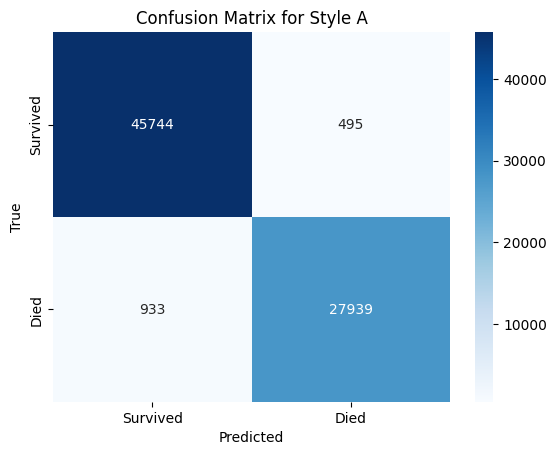

In [176]:
# Train Random Forest for Style A
rf_a = RandomForestClassifier(random_state=42)
rf_a.fit(X_train_scaled_a, y_train_a)

# Evaluate Random Forest for Style A
y_pred_a = rf_a.predict(X_val_scaled_a)
y_pred_proba_a = rf_a.predict_proba(X_val_scaled_a)[:, 1]

print("Classification Report for Style A:")
print(classification_report(y_val_a, y_pred_a))
print("ROC-AUC Score for Style A:", roc_auc_score(y_val_a, y_pred_proba_a))

# Confusion Matrix for Style A
conf_matrix_a = confusion_matrix(y_val_a, y_pred_a)
sns.heatmap(conf_matrix_a, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Style A')
plt.show()

For Style B

Classification Report for Style B:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      2582
           1       0.80      0.69      0.74      1736

    accuracy                           0.80      4318
   macro avg       0.80      0.79      0.79      4318
weighted avg       0.80      0.80      0.80      4318

ROC-AUC Score for Style B: 0.8709458784138326


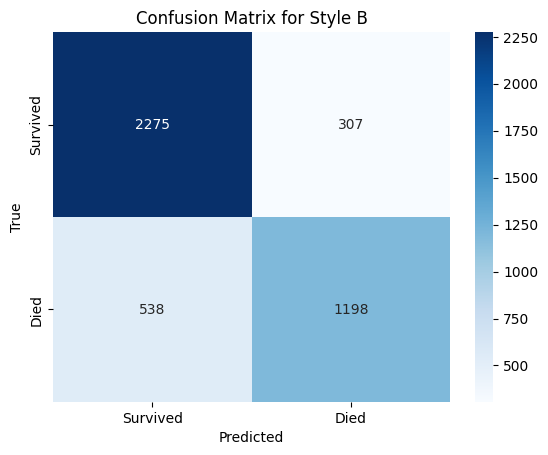

In [177]:
# Train Random Forest for Style B
rf_b = RandomForestClassifier(random_state=42)
rf_b.fit(X_train_scaled_b, y_train_b)

# Evaluate Random Forest for Style B
y_pred_b = rf_b.predict(X_val_scaled_b)
y_pred_proba_b = rf_b.predict_proba(X_val_scaled_b)[:, 1]

print("Classification Report for Style B:")
print(classification_report(y_val_b, y_pred_b))
print("ROC-AUC Score for Style B:", roc_auc_score(y_val_b, y_pred_proba_b))

# Confusion Matrix for Style B
conf_matrix_b = confusion_matrix(y_val_b, y_pred_b)
sns.heatmap(conf_matrix_b, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Style B')
plt.show()

#### **Style A**
- **Accuracy**: 0.98
- **ROC-AUC**: 0.998
- **Precision and Recall**:
  - Class `0` (Survived): Very high precision (0.98) and recall (0.99), indicating minimal false negatives and positives.
  - Class `1` (Died): High precision (0.98) and recall (0.97), showing strong predictive performance with few misclassifications.
- **Confusion Matrix**:
  - Extremely low misclassification rates, with most predictions aligning with the true classes.
  - Model shows robust performance on both classes.
- **Remarks**:
  - Random Forest for Style A performs near perfectly, with strong generalization and minimal overfitting.
  - High ROC-AUC indicates excellent separation between classes.

---

#### **Style B**
- **Accuracy**: 0.80
- **ROC-AUC**: 0.871
- **Precision and Recall**:
  - Class `0` (Survived): Precision (0.81) and recall (0.88) are strong, with relatively few false positives.
  - Class `1` (Died): Precision (0.80) is comparable, but recall (0.69) is slightly lower, suggesting a moderate number of false negatives.
- **Confusion Matrix**:
  - Reasonable balance between true positives and true negatives, though slightly higher misclassification for class `1`.
- **Remarks**:
  - While the performance is solid, Style B suffers from reduced predictive power compared to Style A.
  - Likely due to a smaller dataset size and higher class imbalance.

2. **Hyperparameter Tuning**
   - Use `GridSearchCV` or `RandomizedSearchCV` to tune:
     - `n_estimators`, `max_depth`, `min_samples_split`, and `min_samples_leaf`.
   - Ensure hyperparameter tuning uses stratified K-fold CV.



For Style A

In [178]:
# Define the Random Forest model
rf = RandomForestClassifier(random_state=42, min_samples_split=20) # Restricts Tree Growth, a node must have at least 20 samples to split, to avoid overfitting.

# Define the hyperparameter grid
param_grid_rf = {
    'n_estimators': [10, 20],  # Fewer values for quicker tuning
    'max_features': [5, 10],   # Adjust based on dataset dimensionality
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Create the RandomizedSearchCV object
random_search_rf_a = RandomizedSearchCV(
    estimator=rf,               # Random Forest model
    param_distributions=param_grid_rf,  # Hyperparameter grid
    n_iter=10,                  # Number of random combinations to test
    cv=3,                       # Stratified 3-fold cross-validation
    scoring='f1',               # Scoring metric
    n_jobs=-1,                  # Use all available cores
    random_state=42             # Reproducibility
)

In [179]:
# Stratified sampling for hyperparameter tuning
X_train_a_sample, _, y_train_a_sample, _ = train_test_split(
    X_train_scaled_a, y_train_a,
    test_size=0.9,  # Keep only 10% for tuning; for style A, still ~2 times more than style B
    stratify=y_train_a,
    random_state=42
)
print("Sampled data size for Style A:", X_train_a_sample.shape)

# Hyperparameter tuning with sample
random_search_rf_a.fit(X_train_a_sample, y_train_a_sample)
print(f"Best parameters for Style A: {random_search_rf_a.best_params_}")

# Refit the best model on full training data
best_rf_a = random_search_rf_a.best_estimator_
best_rf_a.fit(X_train_scaled_a, y_train_a)

# Evaluate on validation set
y_pred_a = best_rf_a.predict(X_val_scaled_a)
y_proba_a = best_rf_a.predict_proba(X_val_scaled_a)[:, 1]

# Performance metrics
print("Classification Report (Style A):")
print(classification_report(y_val_a, y_pred_a))

print("ROC-AUC (Style A):", roc_auc_score(y_val_a, y_proba_a))


Sampled data size for Style A: (30044, 25)
Best parameters for Style A: {'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 10}
Classification Report (Style A):
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     46239
         1.0       0.98      0.97      0.98     28872

    accuracy                           0.98     75111
   macro avg       0.98      0.98      0.98     75111
weighted avg       0.98      0.98      0.98     75111

ROC-AUC (Style A): 0.9983149130401192


For Style B

In [180]:
# Create the RandomizedSearchCV object
random_search_rf_b = RandomizedSearchCV(
    estimator=rf,               # Random Forest model
    param_distributions=param_grid_rf,  # Hyperparameter grid
    n_iter=10,                  # Number of random combinations to test
    cv=3,                       # Stratified 3-fold cross-validation
    scoring='f1',               # Scoring metric
    n_jobs=-1,                  # Use all available cores
    random_state=42             # Reproducibility
)

# Hyperparameter tuning with the full training data for Style B
random_search_rf_b.fit(X_train_scaled_b, y_train_b)
print(f"Best parameters for Style B: {random_search_rf_b.best_params_}")

# Refit the best model on full training data
best_rf_b = random_search_rf_b.best_estimator_
best_rf_b.fit(X_train_scaled_b, y_train_b)

# Evaluate on validation set
y_pred_b = best_rf_b.predict(X_val_scaled_b)
y_proba_b = best_rf_b.predict_proba(X_val_scaled_b)[:, 1]

# Performance metrics
print("Classification Report (Style B):")
print(classification_report(y_val_b, y_pred_b))

print("ROC-AUC (Style B):", roc_auc_score(y_val_b, y_proba_b))

Best parameters for Style B: {'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 10}
Classification Report (Style B):
              precision    recall  f1-score   support

           0       0.79      0.86      0.83      2582
           1       0.76      0.66      0.71      1736

    accuracy                           0.78      4318
   macro avg       0.78      0.76      0.77      4318
weighted avg       0.78      0.78      0.78      4318

ROC-AUC (Style B): 0.8531523182472059


#### Comparisons
1. **Model Robustness**:
   - Style A exhibits superior performance due to its larger dataset and feature diversity.
   - Style B, while accurate, is constrained by data size and slightly higher class imbalance.
2. **ROC-AUC**:
   - Style A's near-perfect score highlights its ability to distinguish between classes.
   - Style B's score is respectable but reflects challenges in identifying class `1`.

In [183]:
# Cross-validation on Style A
cv_scores_a = cross_val_score(best_rf_a, X_train_scaled_a, y_train_a, cv=3, scoring='f1')
print("Cross-Validation F1 Scores (Style A):", cv_scores_a)
print("Mean F1 Score (Style A):", cv_scores_a.mean())


Cross-Validation F1 Scores (Style A): [0.97498529 0.97487398 0.97558485]
Mean F1 Score (Style A): 0.9751480390741257


In [181]:
# Cross-validation on Style B
cv_scores_b = cross_val_score(best_rf_b, X_train_scaled_b, y_train_b, cv=3, scoring='f1')
print("Cross-Validation F1 Scores (Style B):", cv_scores_b)
print("Mean F1 Score (Style B):", cv_scores_b.mean())


Cross-Validation F1 Scores (Style B): [0.67928885 0.6751681  0.70445714]
Mean F1 Score (Style B): 0.6863046957169577


#### **Style A Results:**
- **Cross-Validation F1 Scores**: [0.97498529, 0.97487398, 0.97558485]
- **Mean F1 Score**: 0.9751
- **Observations**:
  - The F1 scores across the folds are highly consistent, indicating robust model performance.
  - High F1 score suggests excellent precision and recall, meaning the model predicts both classes effectively with minimal trade-offs.
  - This consistency also reflects the larger dataset size and potentially cleaner feature set for Style A.

---

#### **Style B Results:**
- **Cross-Validation F1 Scores**: [0.67928885, 0.6751681, 0.70445714]
- **Mean F1 Score**: 0.6863
- **Observations**:
  - The F1 scores have more variance between folds compared to Style A, indicating less consistent performance.
  - A lower mean F1 score suggests the model is struggling with trade-offs between precision and recall, especially for the smaller dataset size and potentially noisier or less informative features in Style B.

---

#### **Comparison**:
1. **Performance Consistency**:
   - **Style A** has much lower variance in F1 scores, suggesting better model robustness.
   - **Style B** shows higher variance, indicating the model's sensitivity to the folds in cross-validation.

2. **Model Effectiveness**:
   - The significantly higher mean F1 score for **Style A** (0.9751 vs. 0.6863) demonstrates the advantage of having a larger, cleaner dataset with more relevant features.

---

#### **Next Steps**:
1. If **Style A** represents a more comprehensive dataset, it should be preferred for primary model development.
2. For **Style B**, consider:
   - Additional feature engineering to extract more meaningful information.
   - Exploring alternative models like Gradient Boosting or XGBoost to handle the smaller dataset and potentially noisy features better.

3. **Feature Importance**
   - Visualize feature importance scores to identify key predictors of mortality.

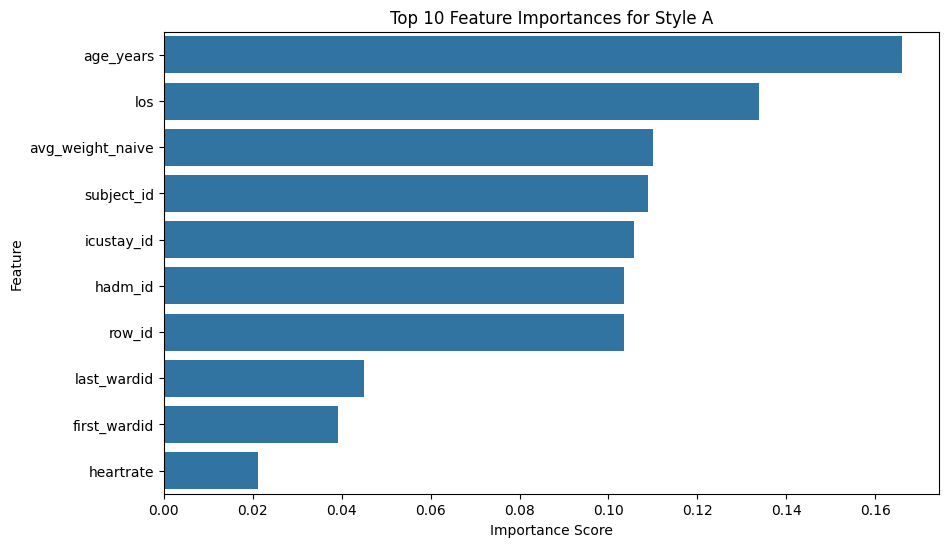

In [191]:
# Correct feature names for Style A
# Use only the numerical columns, which were used for Random Forest training
numerical_columns = X_train_a.select_dtypes(include=['float64', 'int64']).columns
selected_columns = numerical_columns[:len(best_rf_a.feature_importances_)]  # To match feature importance length

# Create feature importance series using correct columns
feature_importance_a = pd.Series(best_rf_a.feature_importances_, index=selected_columns).sort_values(ascending=False)

# Plot Feature Importance for Style A
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_a[:10], y=feature_importance_a.index[:10])
plt.title('Top 10 Feature Importances for Style A')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()



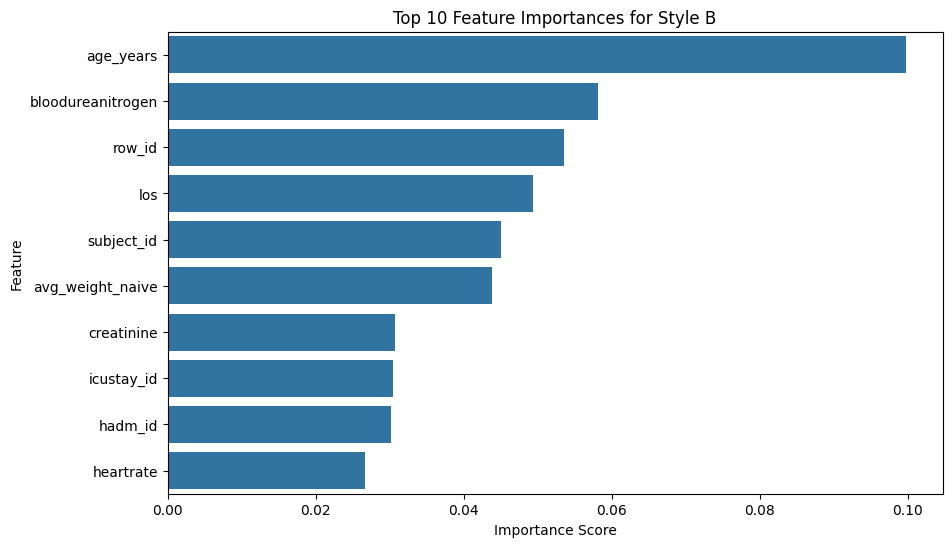

In [192]:
# Correct feature names for Style B
# Use only the numerical columns, which were used for Random Forest training
numerical_columns_b = X_train_b.select_dtypes(include=['float64', 'int64']).columns
selected_columns_b = numerical_columns_b[:len(best_rf_b.feature_importances_)]  # To match feature importance length

# Create feature importance series using correct columns
feature_importance_b = pd.Series(best_rf_b.feature_importances_, index=selected_columns_b).sort_values(ascending=False)

# Plot Feature Importance for Style B
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_b[:10], y=feature_importance_b.index[:10])
plt.title('Top 10 Feature Importances for Style B')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


#### **Style A Feature Importance**:
   - The most important feature by far is `age_years`, followed by `los` (Length of Stay).
   - Features like `avg_weight_naive`, `subject_id`, and `icustay_id` are also relatively important, indicating some patient demographics and identifiers may contribute significantly to the model.

---

#### **Style B Feature Importance**:
   - Similar to Style A, `age_years` is also the top feature.
   - The feature `bloodureanitrogen` is ranked second, which makes sense given its link to kidney function and potentially mortality.
   - Other important features include `row_id`, `los`, and `subject_id`, showing consistency in the importance of patient characteristics across both styles.

---

#### **Key Observations**:
- **Age** is a dominant predictor of mortality in both datasets.
- **Length of Stay (los)** also plays a significant role, suggesting that longer stays may correlate with different outcomes.
- Style B places more emphasis on clinical data (e.g., `bloodureanitrogen`), while Style A has patient identifiers like `avg_weight_naive` and `subject_id` as important features.

#### **2.3 XGBoost**
1. **Baseline Implementation**
   - Train an XGBoost model using default hyperparameters.
   - Evaluate performance on the validation set.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:11:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for Style A (XGBoost):
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90     46239
         1.0       0.87      0.77      0.82     28872

    accuracy                           0.87     75111
   macro avg       0.87      0.85      0.86     75111
weighted avg       0.87      0.87      0.87     75111

ROC-AUC Score for Style A (XGBoost): 0.9432722167627974


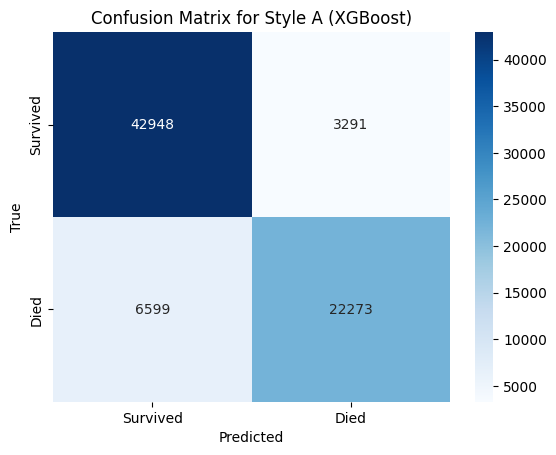

In [194]:
# Train XGBoost model for Style A
xgb_a = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')  # eval_metric prevents warnings
xgb_a.fit(X_train_scaled_a, y_train_a)

# Evaluate XGBoost model for Style A
y_pred_a = xgb_a.predict(X_val_scaled_a)
y_pred_proba_a = xgb_a.predict_proba(X_val_scaled_a)[:, 1]

print("Classification Report for Style A (XGBoost):")
print(classification_report(y_val_a, y_pred_a))
print("ROC-AUC Score for Style A (XGBoost):", roc_auc_score(y_val_a, y_pred_proba_a))

# Confusion Matrix for Style A
conf_matrix_a = confusion_matrix(y_val_a, y_pred_a)
sns.heatmap(conf_matrix_a, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Style A (XGBoost)')
plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:12:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for Style B (XGBoost):
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      2582
           1       0.77      0.71      0.74      1736

    accuracy                           0.80      4318
   macro avg       0.79      0.78      0.78      4318
weighted avg       0.79      0.80      0.79      4318

ROC-AUC Score for Style B (XGBoost): 0.8626326089517289


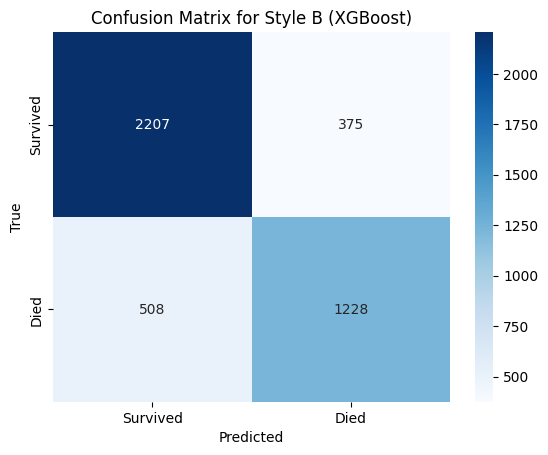

In [195]:
# Train XGBoost model for Style B
xgb_b = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_b.fit(X_train_scaled_b, y_train_b)

# Evaluate XGBoost model for Style B
y_pred_b = xgb_b.predict(X_val_scaled_b)
y_pred_proba_b = xgb_b.predict_proba(X_val_scaled_b)[:, 1]

print("Classification Report for Style B (XGBoost):")
print(classification_report(y_val_b, y_pred_b))
print("ROC-AUC Score for Style B (XGBoost):", roc_auc_score(y_val_b, y_pred_proba_b))

# Confusion Matrix for Style B
conf_matrix_b = confusion_matrix(y_val_b, y_pred_b)
sns.heatmap(conf_matrix_b, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Style B (XGBoost)')
plt.show()

#### **Style A Observations**:
   - **XGBoost** has a ROC-AUC of **0.94**, slightly lower than the Random Forest ROC-AUC.
   - XGBoost achieves **87% accuracy**, but Random Forest reached **98% accuracy** on Style A.

#### **Style B Observations**:
   - **XGBoost** has a ROC-AUC of **0.86**, which is slightly below the Random Forest ROC-AUC for Style B.
   - Both models are close in terms of **accuracy** (~80%).

#### Possible Reasons:
- **Feature Importance**: Random Forest may be leveraging the feature set more effectively, or XGBoost might require additional tuning.
- **Model Complexity**: XGBoost is inherently more complex and might require hyperparameter tuning to outperform Random Forest.

2. **Hyperparameter Tuning**
   - Use `xgb.cv` or `GridSearchCV`/`RandomizedSearchCV` to tune:
     - `learning_rate`, `max_depth`, `n_estimators`, and `subsample`.
   - Ensure stratified K-fold cross-validation for consistent tuning.

Tuning XGBoost for Style A...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:43:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for Style A: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
Best cross-validation ROC-AUC for Style A: 0.9853


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:43:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report for Style A (Tuned XGBoost):
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     46239
         1.0       0.96      0.91      0.93     28872

    accuracy                           0.95     75111
   macro avg       0.95      0.94      0.95     75111
weighted avg       0.95      0.95      0.95     75111

ROC-AUC (Tuned XGBoost - Style A): 0.9880418875477599


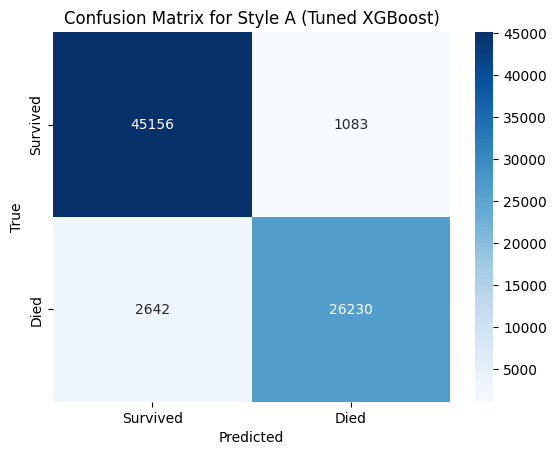

In [200]:
# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, random_state=42, eval_metric="logloss")

# Define the hyperparameter grid
param_grid_xgb = {
    'learning_rate': [0.05, 0.2],  # Step size for gradient descent
    'max_depth': [3, 5, 7],              # Maximum depth of trees
    'n_estimators': [50, 100, 200],    # Number of trees
    'subsample': [0.7, 1.0],      # Subsampling ratio of the training instance
    'colsample_bytree': [0.7, 1.0] # Fraction of features to use for each tree
}

# Create the RandomizedSearchCV object
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid_xgb,
    n_iter=20,                 # Number of parameter combinations to test
    scoring='roc_auc',         # Evaluation metric
    cv=3,                      # Stratified K-fold cross-validation
    verbose=2,                 # Verbosity for progress tracking
    n_jobs=-1,                 # Use all available processors
    random_state=42            # For reproducibility
)

# Hyperparameter tuning with Style A data
print("Tuning XGBoost for Style A...")
random_search_xgb.fit(X_train_scaled_a, y_train_a)

# Print the best parameters and the best score
print(f"Best parameters for Style A: {random_search_xgb.best_params_}")
print(f"Best cross-validation ROC-AUC for Style A: {random_search_xgb.best_score_:.4f}")

# Refit the best model on the full training data
best_xgb_a = random_search_xgb.best_estimator_
best_xgb_a.fit(X_train_scaled_a, y_train_a)

# Evaluate the tuned model on the validation set
y_pred_a = best_xgb_a.predict(X_val_scaled_a)
y_proba_a = best_xgb_a.predict_proba(X_val_scaled_a)[:, 1]

# Print performance metrics
print("\nClassification Report for Style A (Tuned XGBoost):")
print(classification_report(y_val_a, y_pred_a))
print("ROC-AUC (Tuned XGBoost - Style A):", roc_auc_score(y_val_a, y_proba_a))

# Confusion matrix
conf_matrix_a = confusion_matrix(y_val_a, y_pred_a)
sns.heatmap(conf_matrix_a, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Style A (Tuned XGBoost)')
plt.show()



Tuning XGBoost for Style B...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:55:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for Style B: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
Best cross-validation ROC-AUC for Style B: 0.8683


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:55:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report for Style B (Tuned XGBoost):
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2582
           1       0.82      0.76      0.79      1736

    accuracy                           0.84      4318
   macro avg       0.83      0.82      0.83      4318
weighted avg       0.84      0.84      0.84      4318

ROC-AUC (Tuned XGBoost - Style B): 0.9046277490032019


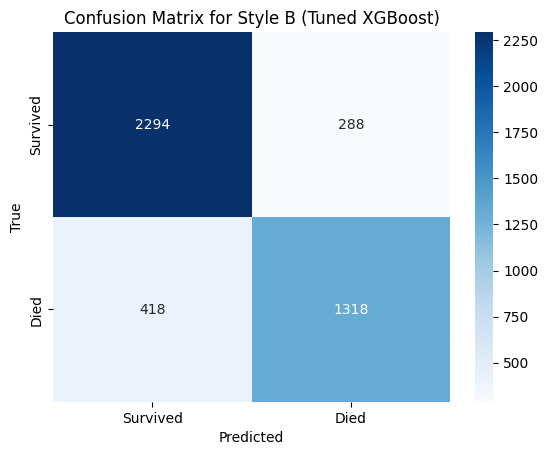

In [201]:
# Define the XGBoost model
xgb_model_b = XGBClassifier(use_label_encoder=False, random_state=42, eval_metric="logloss")

# Define the hyperparameter grid
param_grid_xgb_b = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Learning rate
    'max_depth': [3, 5, 7, 9],              # Maximum depth of trees
    'n_estimators': [50, 100, 200, 300],    # Number of boosting rounds
    'subsample': [0.5, 0.7, 0.8, 1.0],      # Subsampling ratio of the training instance
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0] # Fraction of features to use for each tree
}

# Create the RandomizedSearchCV object
random_search_xgb_b = RandomizedSearchCV(
    estimator=xgb_model_b,
    param_distributions=param_grid_xgb_b,
    n_iter=20,                 # Number of parameter combinations to test
    scoring='roc_auc',         # Evaluation metric
    cv=3,                      # Stratified K-fold cross-validation
    verbose=2,                 # Verbosity for progress tracking
    n_jobs=-1,                 # Use all available processors
    random_state=42            # For reproducibility
)

# Hyperparameter tuning with Style B data
print("Tuning XGBoost for Style B...")
random_search_xgb_b.fit(X_train_scaled_b, y_train_b)

# Print the best parameters and the best score
print(f"Best parameters for Style B: {random_search_xgb_b.best_params_}")
print(f"Best cross-validation ROC-AUC for Style B: {random_search_xgb_b.best_score_:.4f}")

# Refit the best model on the full training data
best_xgb_b = random_search_xgb_b.best_estimator_
best_xgb_b.fit(X_train_scaled_b, y_train_b)

# Evaluate the tuned model on the validation set
y_pred_b_tuned = best_xgb_b.predict(X_val_scaled_b)
y_proba_b_tuned = best_xgb_b.predict_proba(X_val_scaled_b)[:, 1]

# Print performance metrics
print("\nClassification Report for Style B (Tuned XGBoost):")
print(classification_report(y_val_b, y_pred_b_tuned))
print("ROC-AUC (Tuned XGBoost - Style B):", roc_auc_score(y_val_b, y_proba_b_tuned))

# Confusion matrix
conf_matrix_b = confusion_matrix(y_val_b, y_pred_b_tuned)
sns.heatmap(conf_matrix_b, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Style B (Tuned XGBoost)')
plt.show()


#### **Comparison:**
- **Style A:** Exhibits much higher ROC-AUC and overall accuracy, indicating that the tuned XGBoost model performs very well on this dataset.
- **Style B:** While there is significant improvement from baseline, the performance remains lower than Style A due to the smaller dataset size and higher complexity.

#### **Conclusion:**
- For **Style A**, XGBoost with hyperparameter tuning is a robust and highly accurate model.
- For **Style B**, further improvements may require feature engineering or dataset augmentation to achieve similar performance.

3. **Robustness**
   - Compare performance across cross-validation folds and against the validation set.

ANN For Style A

In [228]:
# Build the ANN model
model_a = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled_a.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_a.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define EarlyStopping with stricter settings
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=3,                 # Stop after 3 epochs of no improvement
    min_delta=0.001,            # Minimum improvement to reset patience
    restore_best_weights=True   # Restore weights from the best epoch
)

# Train the model
history_a = model_a.fit(
    X_train_scaled_a, y_train_a,
    validation_data=(X_val_scaled_a, y_val_a),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9389/9389 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7086 - loss: 0.5653 - val_accuracy: 0.7201 - val_loss: 0.5501
Epoch 2/50
9389/9389 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.7236 - loss: 0.5458 - val_accuracy: 0.7255 - val_loss: 0.5445
Epoch 3/50
9389/9389 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.7267 - loss: 0.5396 - val_accuracy: 0.7287 - val_loss: 0.5878
Epoch 4/50
9389/9389 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.7328 - loss: 0.5304 - val_accuracy: 0.7320 - val_loss: 0.5462
Epoch 5/50
9389/9389 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.7383 - loss: 0.5222 - val_accuracy: 0.7344 - val_loss: 0.8456


In [229]:
# Evaluate on validation data
y_pred_proba_a = model_a.predict(X_val_scaled_a).ravel()
y_pred_a = (y_pred_proba_a > 0.5).astype(int)

# Classification report and ROC-AUC
print("\nClassification Report for Style A (ANN):")
print(classification_report(y_val_a, y_pred_a))
print("ROC-AUC for Style A (ANN):", roc_auc_score(y_val_a, y_pred_proba_a))

2348/2348 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Classification Report for Style A (ANN):
              precision    recall  f1-score   support

         0.0       0.75      0.82      0.79     46239
         1.0       0.67      0.57      0.61     28872

    accuracy                           0.73     75111
   macro avg       0.71      0.70      0.70     75111
weighted avg       0.72      0.73      0.72     75111

ROC-AUC for Style A (ANN): 0.7814657708409853


ANN For Style B

In [230]:
# Build the ANN model
model_b = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled_b.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_b.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define EarlyStopping with stricter settings
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=3,                 # Stop after 3 epochs of no improvement
    min_delta=0.001,            # Minimum improvement to reset patience
    restore_best_weights=True   # Restore weights from the best epoch
)

# Train the model
history_b = model_b.fit(
    X_train_scaled_b, y_train_b,
    validation_data=(X_val_scaled_b, y_val_b),
    epochs=50,                   # High max epochs; training will stop early
    batch_size=32,
    callbacks=[early_stopping]   # Pass the EarlyStopping callback
)




Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6752 - loss: 0.6027 - val_accuracy: 0.7283 - val_loss: 0.5459
Epoch 2/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7427 - loss: 0.5183 - val_accuracy: 0.7293 - val_loss: 0.5331
Epoch 3/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7502 - loss: 0.5108 - val_accuracy: 0.7330 - val_loss: 0.5327
Epoch 4/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7551 - loss: 0.4976 - val_accuracy: 0.7351 - val_loss: 0.5242
Epoch 5/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7655 - loss: 0.4870 - val_accuracy: 0.7459 - val_loss: 0.5226
Epoch 6/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7648 - loss: 0.4844 - val_accuracy: 0.7422 - val_loss: 0.5221
Epoch 7/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7741 - loss: 0.4722 - val_accuracy: 0.7415 - val_loss: 0.5283
Epoch 8/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7826 - loss: 0.4695 - val_accuracy: 0.7436 - val_

In [231]:
# Evaluate on validation data
y_pred_proba_b = model_b.predict(X_val_scaled_b).ravel()
y_pred_b = (y_pred_proba_b > 0.5).astype(int)

# Classification report and ROC-AUC
print("\nClassification Report for Style B (ANN):")
print(classification_report(y_val_b, y_pred_b))
print("ROC-AUC for Style B (ANN):", roc_auc_score(y_val_b, y_pred_proba_b))

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report for Style B (ANN):
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      2582
           1       0.70      0.65      0.67      1736

    accuracy                           0.75      4318
   macro avg       0.74      0.73      0.73      4318
weighted avg       0.74      0.75      0.74      4318

ROC-AUC for Style B (ANN): 0.8104035559902479


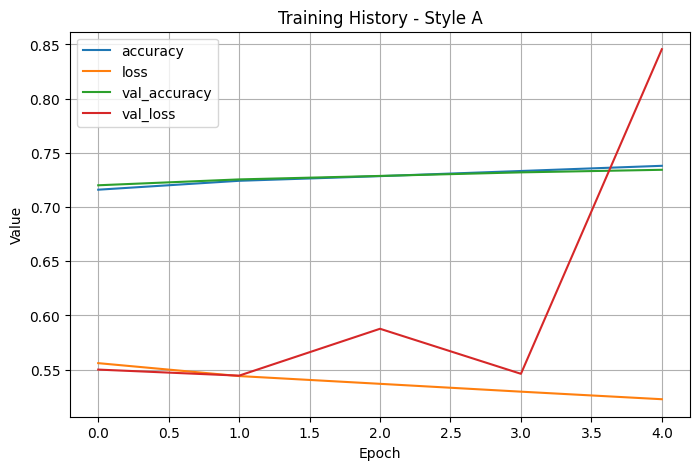

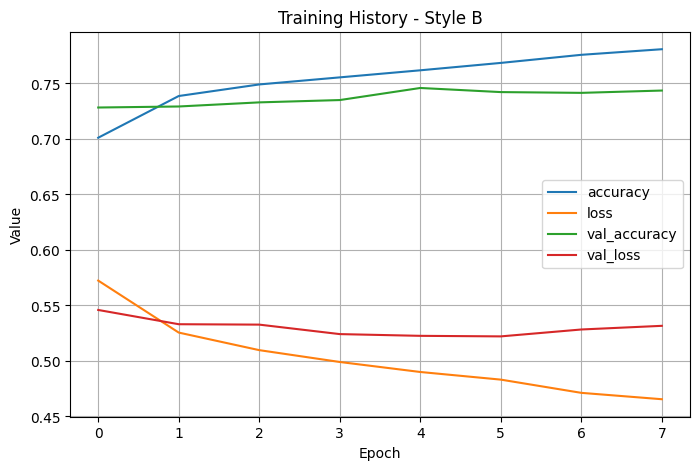

In [232]:
# Plot training and validation loss and accuracy for Style A
def plot_training_history(history, style_name):
    pd.DataFrame(history.history).plot(
        figsize=(8, 5), grid=True,
        title=f'Training History - {style_name}',
        xlabel='Epoch',
        ylabel='Value'
    )
    plt.show()

plot_training_history(history_a, "Style A")
plot_training_history(history_b, "Style B")


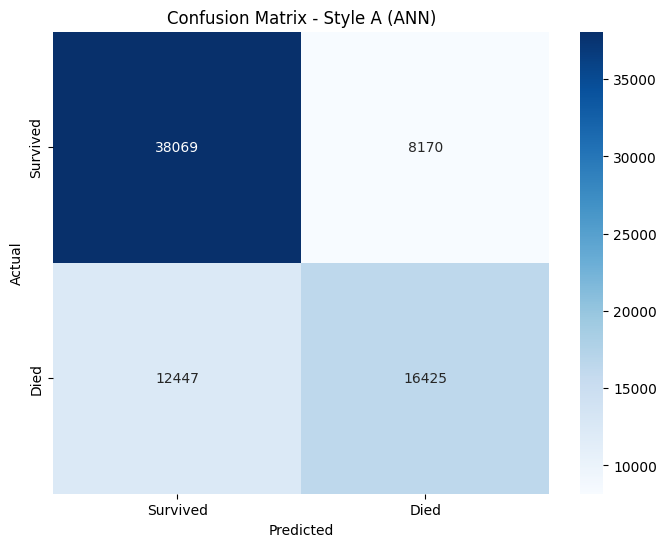

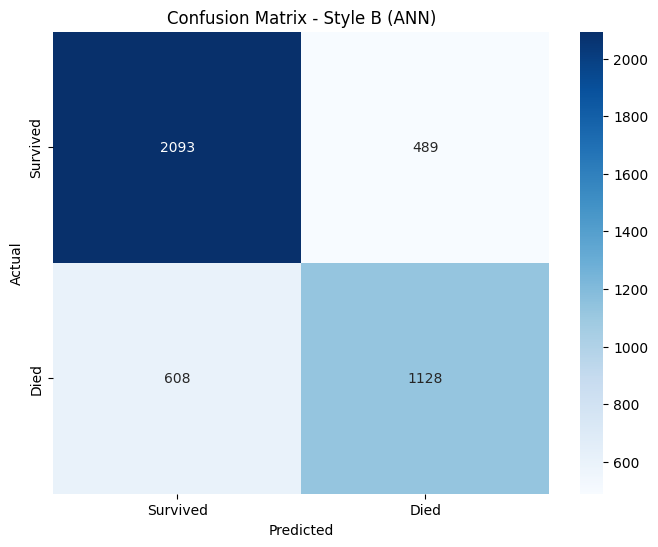

In [235]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, style_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {style_name}')
    plt.show()

# Confusion Matrix for Style A
plot_confusion_matrix(y_val_a, y_pred_a, "Style A (ANN)")

# Confusion Matrix for Style B
plot_confusion_matrix(y_val_b, y_pred_b, "Style B (ANN)")


#### **Performance Metrics**
- **Style A**:
  - **Accuracy**: 0.73
  - **ROC-AUC**: 0.781
  - **Confusion Matrix Insights**:
    - High recall for "Survived" (82%), but relatively low recall for "Died" (57%).
    - False negatives (misclassifying "Died" as "Survived") remain a challenge.
  - **Training History**:
    - The training and validation accuracy improved over epochs.
    - The validation loss increased after a few epochs, indicating some overfitting.

- **Style B**:
  - **Accuracy**: 0.75
  - **ROC-AUC**: 0.810
  - **Confusion Matrix Insights**:
    - Better balance between precision and recall compared to Style A.
    - False positives are slightly higher than false negatives.
  - **Training History**:
    - Training accuracy continues to rise, while validation accuracy stabilizes after several epochs.
    - A smaller validation loss increase suggests reduced overfitting compared to Style A.

#### **Observations**
   - **Accuracy vs. AUC**: While the accuracy (~74%) is moderate, the ROC-AUC (~0.80) suggest reasonable performance of the model's to distinguish between classes beyond simple accuracy. Style B edging closer to an ideal score.
   - **Improvements Needed**: Precision and recall for class `1` can be improved, especially in Style A, where recall is lower.


#### **Conclusion**
   - The ANN model performs moderately well but does not outperform Random Forest or XGBoost in ROC-AUC and F1-score. ANN still provides an interpretable structure for examining nonlinear relationships. However, this highlights the importance of model selection based on dataset characteristics and computational trade-offs.

### **Section 3: Interpretation and Comparison of Results**

1. **Model Comparisons**
   - Compare performance metrics (e.g., ROC-AUC, precision, recall, F1-score) across all three models.
   - Summarize key insights:
     - Which model performed best overall?
     - Trade-offs between interpretability (Logistic Regression) and predictive power (Random Forest/XGBoost).

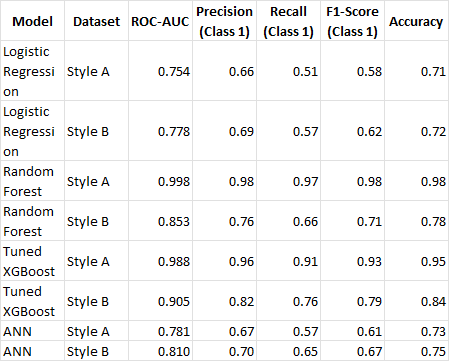

- Best Overall Model: Tuned XGBoost achieved the highest ROC-AUC (Style A: 0.988; Style B: 0.905) and strong balance between precision and recall.
- Insights:
  - Logistic Regression is simpler and interpretable but performs poorly compared to tree-based models.
  - Random Forest and XGBoost excel in predictive power, especially with larger datasets (e.g., Style A).
  - Random Forest shows slightly better feature importance interpretation, while XGBoost benefits from robust hyperparameter tuning.

2. **Visualizations**
   - Plot ROC curves for all models on the same graph to compare performance visually.
   - Display confusion matrices for the tuned versions of each model.


2348/2348 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2348/2348 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


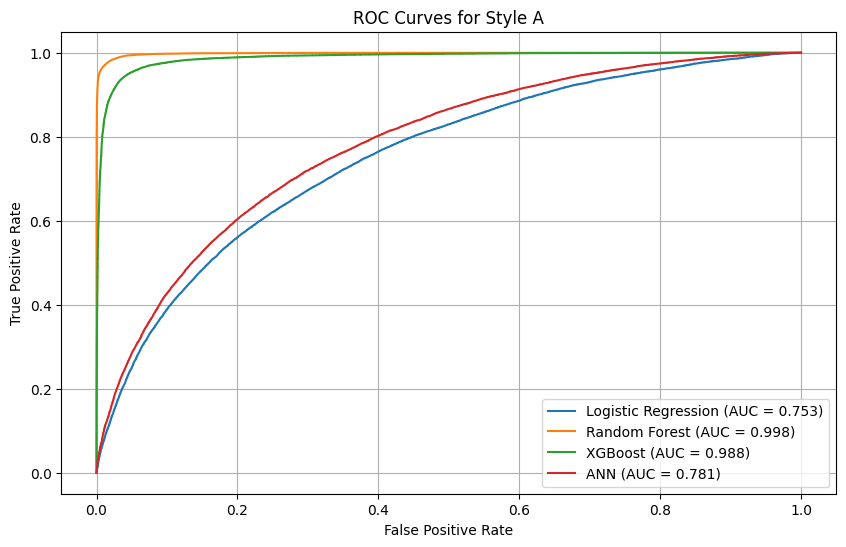

In [240]:
from sklearn.metrics import roc_curve, auc

# Generate ROC curves for Style A
fpr_lr_a, tpr_lr_a, _ = roc_curve(y_val_a, best_logreg.predict_proba(X_val_scaled_a)[:, 1])
fpr_rf_a, tpr_rf_a, _ = roc_curve(y_val_a, best_rf_a.predict_proba(X_val_scaled_a)[:, 1])
fpr_xgb_a, tpr_xgb_a, _ = roc_curve(y_val_a, best_xgb_a.predict_proba(X_val_scaled_a)[:, 1])
fpr_ann_a, tpr_ann_a, _ = roc_curve(y_val_a, model_a.predict(X_val_scaled_a).ravel())  # Ensure 'model_a' is the ANN model for Style A

# Plot ROC curves for Style A
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr_a, tpr_lr_a, label=f'Logistic Regression (AUC = {roc_auc_score(y_val_a, best_logreg.predict_proba(X_val_scaled_a)[:, 1]):.3f})')
plt.plot(fpr_rf_a, tpr_rf_a, label=f'Random Forest (AUC = {roc_auc_score(y_val_a, best_rf_a.predict_proba(X_val_scaled_a)[:, 1]):.3f})')
plt.plot(fpr_xgb_a, tpr_xgb_a, label=f'XGBoost (AUC = {roc_auc_score(y_val_a, best_xgb_a.predict_proba(X_val_scaled_a)[:, 1]):.3f})')
plt.plot(fpr_ann_a, tpr_ann_a, label=f'ANN (AUC = {roc_auc_score(y_val_a, model_a.predict(X_val_scaled_a).ravel()):.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Style A')
plt.legend()
plt.grid(True)
plt.show()



135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


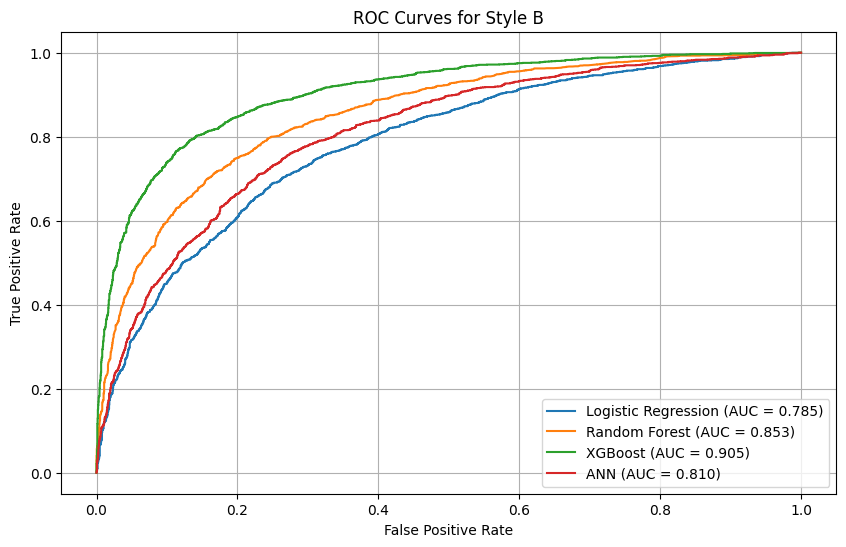

In [239]:
# Generate ROC curves for Style B
fpr_lr_b, tpr_lr_b, _ = roc_curve(y_val_b, best_logreg_b.predict_proba(X_val_scaled_b)[:, 1])
fpr_rf_b, tpr_rf_b, _ = roc_curve(y_val_b, best_rf_b.predict_proba(X_val_scaled_b)[:, 1])
fpr_xgb_b, tpr_xgb_b, _ = roc_curve(y_val_b, best_xgb_b.predict_proba(X_val_scaled_b)[:, 1])
fpr_ann_b, tpr_ann_b, _ = roc_curve(y_val_b, model_b.predict(X_val_scaled_b).ravel())  # Ensure 'ann_model_b' is the ANN model for Style B

# Plot ROC curves for Style B
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr_b, tpr_lr_b, label=f'Logistic Regression (AUC = {roc_auc_score(y_val_b, best_logreg_b.predict_proba(X_val_scaled_b)[:, 1]):.3f})')
plt.plot(fpr_rf_b, tpr_rf_b, label=f'Random Forest (AUC = {roc_auc_score(y_val_b, best_rf_b.predict_proba(X_val_scaled_b)[:, 1]):.3f})')
plt.plot(fpr_xgb_b, tpr_xgb_b, label=f'XGBoost (AUC = {roc_auc_score(y_val_b, best_xgb_b.predict_proba(X_val_scaled_b)[:, 1]):.3f})')
plt.plot(fpr_ann_b, tpr_ann_b, label=f'ANN (AUC = {roc_auc_score(y_val_b, model_b.predict(X_val_scaled_b).ravel()):.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Style B')
plt.legend()
plt.grid(True)
plt.show()



- **Style A:**
  - **Random Forest** significantly outperforms other models with a nearly perfect ROC-AUC score (0.998), followed by **XGBoost** (0.988).
  - **ANN** performs moderately well (0.781) but lags behind XGBoost and Random Forest.
  - **Logistic Regression** has the lowest ROC-AUC (0.753).

- **Style B:**
  - **XGBoost** achieves the highest ROC-AUC score (0.905), followed by **ANN** (0.810).
  - **Random Forest** (0.853) performs better than Logistic Regression (0.785) but worse than XGBoost and ANN.

3. **Feature Importance**
   - Highlight and interpret the most important features from Random Forest and XGBoost.
   - Discuss their clinical relevance and impact on predictions.

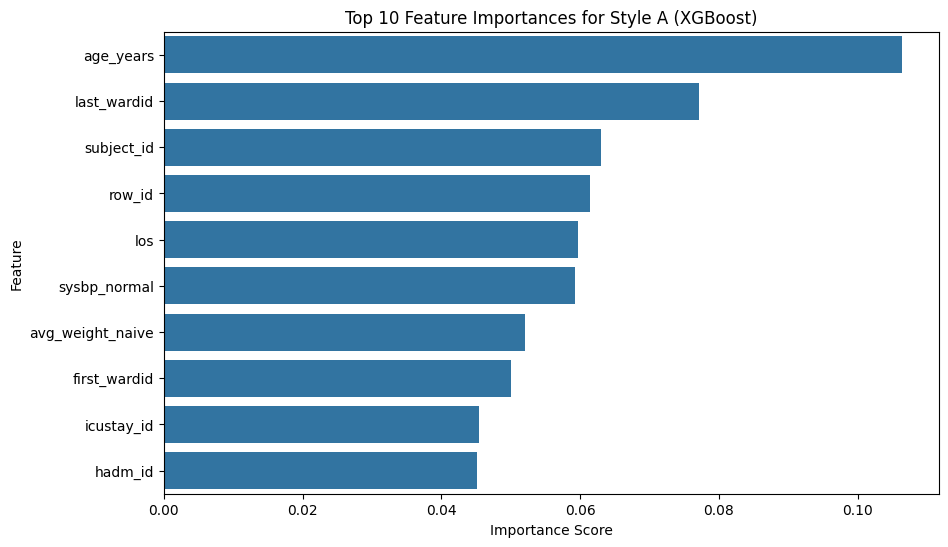

In [207]:
# Feature Importance for Style A (XGBoost)
# Use only numerical columns from the training data for Style A
numerical_columns_a = X_train_a.select_dtypes(include=['float64', 'int64']).columns
selected_columns_a_xgb = numerical_columns_a[:len(best_xgb_a.feature_importances_)]  # Match the length of feature importances

# Create feature importance series using correct columns
xgb_feature_importance_a = pd.Series(best_xgb_a.feature_importances_, index=selected_columns_a_xgb).sort_values(ascending=False)

# Plot Feature Importance for Style A (XGBoost)
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_feature_importance_a[:10], y=xgb_feature_importance_a.index[:10])
plt.title('Top 10 Feature Importances for Style A (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()




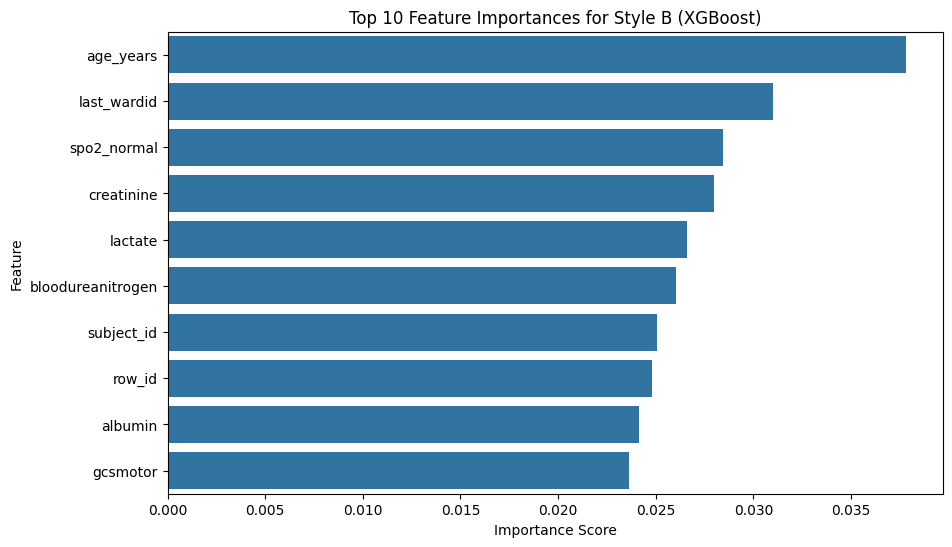

In [206]:
# Feature Importance for Style B (XGBoost)
# Use only numerical columns from the training data for Style B
numerical_columns_b = X_train_b.select_dtypes(include=['float64', 'int64']).columns
selected_columns_b_xgb = numerical_columns_b[:len(best_xgb_b.feature_importances_)]  # Match the length of feature importances

# Create feature importance series using correct columns
xgb_feature_importance_b = pd.Series(best_xgb_b.feature_importances_, index=selected_columns_b_xgb).sort_values(ascending=False)

# Plot Feature Importance for Style B (XGBoost)
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_feature_importance_b[:10], y=xgb_feature_importance_b.index[:10])
plt.title('Top 10 Feature Importances for Style B (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

## Research Question 2: Weekend Effect in ICU

### **Define the Hypothesis**
- **Null Hypothesis (H₀):** Admission to the ICU on weekends does not increase the risk of mortality.
- **Alternative Hypothesis (H₁):** Admission to the ICU on weekends increases the risk of mortality.


In [11]:
# Define file path for the new processed dataset
file_path = project_path / 'data_aim2.csv'

# Reload the processed dataset
data_aim2 = pd.read_csv(file_path)

<ipython-input-11-bbe658f3cc4f>:5: DtypeWarning: Columns (15,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  data_aim2 = pd.read_csv(file_path)


In [12]:
# Drop columns with >25% missing
missing_percentages_aim2 = data_aim2.isnull().mean() * 100
columns_to_drop_aim2 = missing_percentages_aim2[missing_percentages_aim2 > 25].index
data_style_a_aim2 = data_aim2.drop(columns=columns_to_drop_aim2)

# Identify numeric columns for imputation
numeric_columns_to_impute_aim2 = data_style_a_aim2.select_dtypes(include=['float64', 'int64']).columns.intersection(
    missing_percentages_aim2[missing_percentages_aim2 <= 25].index
)

# Impute missing values for numeric columns
imputer_aim2 = SimpleImputer(strategy='mean')
data_style_a_aim2[numeric_columns_to_impute_aim2] = imputer_aim2.fit_transform(data_style_a_aim2[numeric_columns_to_impute_aim2])

print(f"Dataset Style A for Aim 2 after dropping columns >25% missing and imputing numeric values: {data_style_a_aim2.shape}")

# Save processed dataset for analysis
data_style_a_aim2.to_csv('data_style_a_aim2.csv', index=False)
print("data_style_a_aim2.csv saved successfully!")


Dataset Style A for Aim 2 after dropping columns >25% missing and imputing numeric values: (375552, 47)
data_style_a_aim2.csv saved successfully!


In [13]:
# Define threshold for "enough data" (e.g., ≥75% of columns must have non-NaN values)
threshold_aim2 = int(0.75 * data_aim2.shape[1])

# Filter rows with enough data and make a copy to avoid SettingWithCopyWarning
data_style_b_aim2 = data_aim2.dropna(thresh=threshold_aim2).copy()
print(f"Dataset Style B for Aim 2 after filtering rows with enough data: {data_style_b_aim2.shape}")

# Separate columns by data type
numeric_columns_aim2 = data_style_b_aim2.select_dtypes(include=['float64', 'int64']).columns
categorical_columns_aim2 = data_style_b_aim2.select_dtypes(include=['object', 'category']).columns
boolean_columns_aim2 = data_style_b_aim2.select_dtypes(include=['bool']).columns

# Impute numeric columns with mean
numeric_imputer_aim2 = SimpleImputer(strategy='mean')
data_style_b_aim2.loc[:, numeric_columns_aim2] = pd.DataFrame(
    numeric_imputer_aim2.fit_transform(data_style_b_aim2[numeric_columns_aim2]),
    columns=numeric_columns_aim2,
    index=data_style_b_aim2.index
)

# Impute categorical columns with the most frequent value
categorical_imputer_aim2 = SimpleImputer(strategy='most_frequent')
data_style_b_aim2.loc[:, categorical_columns_aim2] = pd.DataFrame(
    categorical_imputer_aim2.fit_transform(data_style_b_aim2[categorical_columns_aim2]),
    columns=categorical_columns_aim2,
    index=data_style_b_aim2.index
)

# Handle boolean columns
# Step 1: Convert boolean columns to integers and store temporarily
boolean_data_as_int_aim2 = data_style_b_aim2[boolean_columns_aim2].astype('int')

# Step 2: Impute missing values for boolean columns (as integers)
boolean_imputed_aim2 = pd.DataFrame(
    SimpleImputer(strategy='most_frequent').fit_transform(boolean_data_as_int_aim2),
    columns=boolean_columns_aim2,
    index=data_style_b_aim2.index
)

# Step 3: Convert back to boolean and assign to the dataframe
data_style_b_aim2.loc[:, boolean_columns_aim2] = boolean_imputed_aim2.astype('bool')

# Confirm the shape of the dataset after imputation
print(f"Dataset Style B for Aim 2 after imputing missing values: {data_style_b_aim2.shape}")

# Save processed dataset for analysis
data_style_b_aim2.to_csv('data_style_b_aim2.csv', index=False)
print("data_style_b_aim2.csv saved successfully!")


Dataset Style B for Aim 2 after filtering rows with enough data: (21586, 81)
Dataset Style B for Aim 2 after imputing missing values: (21586, 81)
data_style_b_aim2.csv saved successfully!


In [14]:
# Calculate mortality rates for Style A
weekend_mortality_rate_a = data_style_a_aim2[data_style_a_aim2['is_weekend_admission'] == 1]['expire_flag'].mean()
weekday_mortality_rate_a = data_style_a_aim2[data_style_a_aim2['is_weekend_admission'] == 0]['expire_flag'].mean()

print("Style A - Weekend Mortality Rate:", weekend_mortality_rate_a)
print("Style A - Weekday Mortality Rate:", weekday_mortality_rate_a)

# Calculate mortality rates for Style B
weekend_mortality_rate_b = data_style_b_aim2[data_style_b_aim2['is_weekend_admission'] == 1]['expire_flag'].mean()
weekday_mortality_rate_b = data_style_b_aim2[data_style_b_aim2['is_weekend_admission'] == 0]['expire_flag'].mean()

print("Style B - Weekend Mortality Rate:", weekend_mortality_rate_b)
print("Style B - Weekday Mortality Rate:", weekday_mortality_rate_b)



Style A - Weekend Mortality Rate: 0.4117292500256489
Style A - Weekday Mortality Rate: 0.37722800225824665
Style B - Weekend Mortality Rate: 0.43525741029641185
Style B - Weekday Mortality Rate: 0.3932393707234341


<ipython-input-15-14a88355305f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=rates_a, palette="Blues")


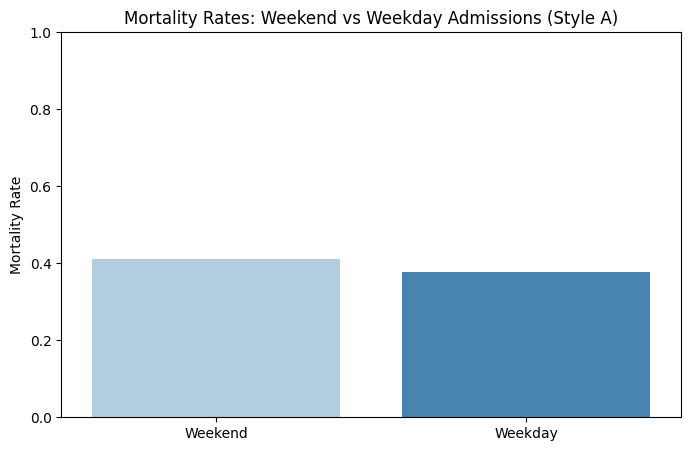

In [15]:
# For Style A
rates_a = [weekend_mortality_rate_a, weekday_mortality_rate_a]
labels = ['Weekend', 'Weekday']

plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=rates_a, palette="Blues")
plt.ylim(0, 1)  # Ensure the y-axis is consistent for comparison
plt.ylabel('Mortality Rate')
plt.title('Mortality Rates: Weekend vs Weekday Admissions (Style A)')
plt.show()



<ipython-input-16-fe3a6b278752>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=rates_b, palette="Greens")


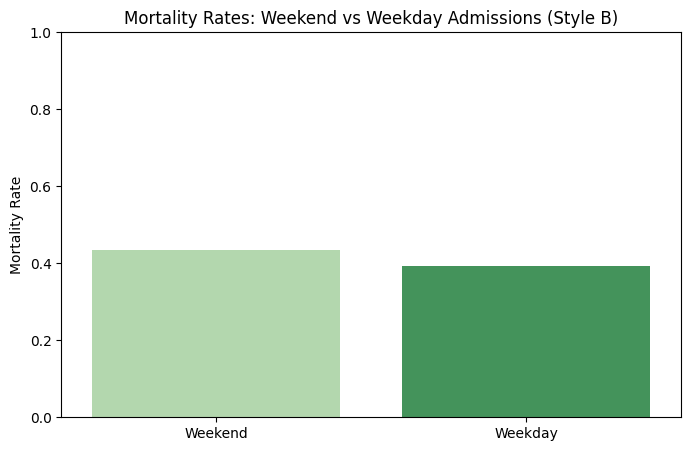

In [16]:
# For Style B
rates_b = [weekend_mortality_rate_b, weekday_mortality_rate_b]
labels = ['Weekend', 'Weekday']

plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=rates_b, palette="Greens")
plt.ylim(0, 1)  # Ensure the y-axis is consistent for comparison
plt.ylabel('Mortality Rate')
plt.title('Mortality Rates: Weekend vs Weekday Admissions (Style B)')
plt.show()

In [18]:
from scipy.stats import chi2_contingency

# Chi-Square Test for Style A
contingency_table_a = pd.crosstab(data_style_a_aim2['is_weekend_admission'], data_style_a_aim2['expire_flag'])
chi2_a, p_a, dof_a, expected_a = chi2_contingency(contingency_table_a)

print("=== Chi-Square Test for Style A ===")
print(f"Chi-Square Statistic (Style A): {chi2_a}")
print(f"P-value (Style A): {p_a}")
print(f"Degrees of Freedom (Style A): {dof_a}")
print("Expected Frequencies (Style A):")
print(expected_a)


=== Chi-Square Test for Style A ===
Chi-Square Statistic (Style A): 310.6534891767871
P-value (Style A): 1.5735007336690635e-69
Degrees of Freedom (Style A): 1
Expected Frequencies (Style A):
[[183190.31230828 114385.68769172]
 [ 48002.68769172  29973.31230828]]


In [19]:
# Chi-Square Test for Style B
contingency_table_b = pd.crosstab(data_style_b_aim2['is_weekend_admission'], data_style_b_aim2['expire_flag'])
chi2_b, p_b, dof_b, expected_b = chi2_contingency(contingency_table_b)

print("\n=== Chi-Square Test for Style B ===")
print(f"Chi-Square Statistic (Style B): {chi2_b}")
print(f"P-value (Style B): {p_b}")
print(f"Degrees of Freedom (Style B): {dof_b}")
print("Expected Frequencies (Style B):")
print(expected_b)



=== Chi-Square Test for Style B ===
Chi-Square Statistic (Style B): 25.929578209787053
P-value (Style B): 3.5410166266330125e-07
Degrees of Freedom (Style B): 1
Expected Frequencies (Style B):
[[10225.65510053  6873.34489947]
 [ 2683.34489947  1803.65510053]]


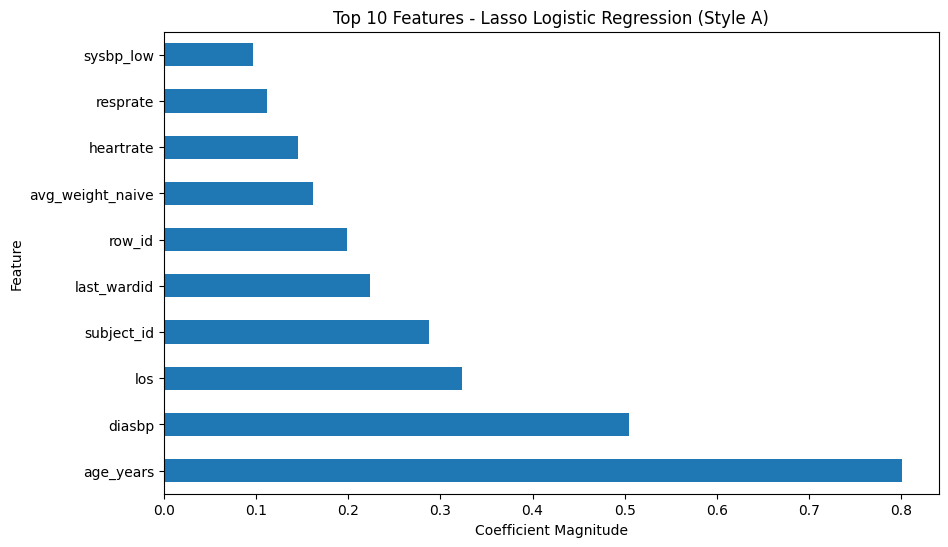

In [256]:
# Logistic Regression with Lasso Regularization for Style A
lasso_model_a = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lasso_model_a.fit(X_train_scaled_a, y_train_a)

# Get feature importance (absolute coefficients) for Style A
feature_importance_lasso_a = pd.Series(
    abs(lasso_model_a.coef_[0]),
    index=numerical_columns_a
).sort_values(ascending=False)

# Plot top 10 features for Style A
plt.figure(figsize=(10, 6))
feature_importance_lasso_a[:10].plot(kind='barh', title="Top 10 Features - Lasso Logistic Regression (Style A)")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.show()

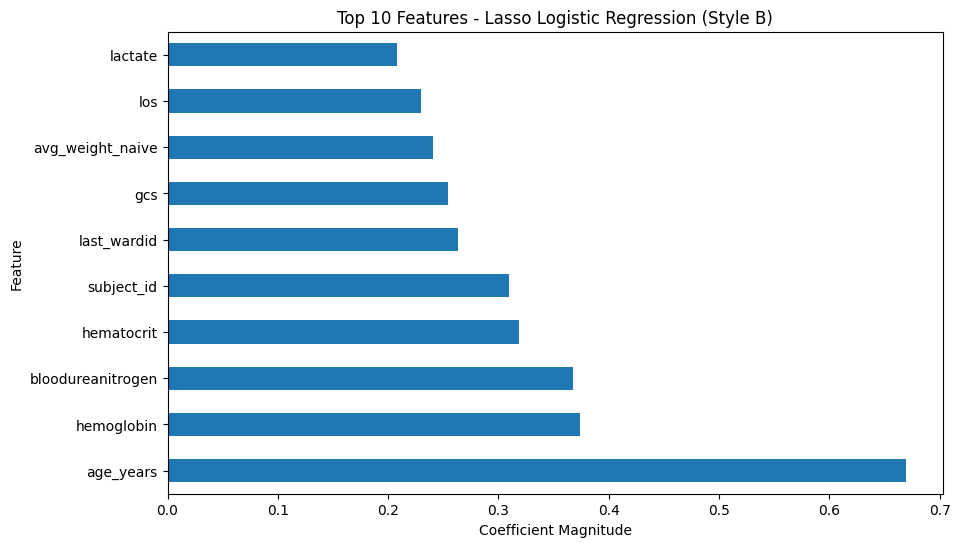

In [257]:
# Logistic Regression with Lasso Regularization for Style B
lasso_model_b = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lasso_model_b.fit(X_train_scaled_b, y_train_b)

# Get feature importance (absolute coefficients) for Style B
feature_importance_lasso_b = pd.Series(
    abs(lasso_model_b.coef_[0]),
    index=numerical_columns_b
).sort_values(ascending=False)

# Plot top 10 features for Style B
plt.figure(figsize=(10, 6))
feature_importance_lasso_b[:10].plot(kind='barh', title="Top 10 Features - Lasso Logistic Regression (Style B)")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.show()

Propensity Score Matching

In [20]:
from sklearn.neighbors import NearestNeighbors

# Logistic Regression for Propensity Score Calculation
propensity_model_a = LogisticRegression(solver='liblinear', random_state=42)

# Select covariates for Style A
X_covariates_a = data_style_a_aim2[['age_years', 'diasbp', 'los', 'last_wardid', 'avg_weight_naive']]  # Update based on available variables
y_treatment_a = data_style_a_aim2['is_weekend_admission']  # Treatment variable

# Fit the logistic regression model
propensity_model_a.fit(X_covariates_a, y_treatment_a)

# Get propensity scores
propensity_scores_a = propensity_model_a.predict_proba(X_covariates_a)[:, 1]

# Perform Nearest Neighbors Matching
nn_matcher_a = NearestNeighbors(n_neighbors=1)
nn_matcher_a.fit(propensity_scores_a.reshape(-1, 1))

# Find matches
matched_indices_a = nn_matcher_a.kneighbors(propensity_scores_a.reshape(-1, 1), return_distance=False).flatten()

# Create matched dataset
matched_data_a = data_style_a_aim2.iloc[matched_indices_a].reset_index(drop=True)

# Save matched dataset
matched_data_a.to_csv("matched_data_a.csv", index=False)
print("Matched dataset for Style A saved as 'matched_data_a.csv'")



Matched dataset for Style A saved as 'matched_data_a.csv'


In [21]:
# Logistic Regression for Propensity Score Calculation
propensity_model_b = LogisticRegression(solver='liblinear', random_state=42)

# Select covariates for Style B
X_covariates_b = data_style_b_aim2[['age_years', 'hematocrit', 'gcs', 'hemoglobin', 'bloodureanitrogen']]  # Update based on available variables
y_treatment_b = data_style_b_aim2['is_weekend_admission']  # Treatment variable

# Fit the logistic regression model
propensity_model_b.fit(X_covariates_b, y_treatment_b)

# Get propensity scores
propensity_scores_b = propensity_model_b.predict_proba(X_covariates_b)[:, 1]

# Perform Nearest Neighbors Matching
nn_matcher_b = NearestNeighbors(n_neighbors=1)
nn_matcher_b.fit(propensity_scores_b.reshape(-1, 1))

# Find matches
matched_indices_b = nn_matcher_b.kneighbors(propensity_scores_b.reshape(-1, 1), return_distance=False).flatten()

# Create matched dataset
matched_data_b = data_style_b_aim2.iloc[matched_indices_b].reset_index(drop=True)

# Save matched dataset
matched_data_b.to_csv("matched_data_b.csv", index=False)
print("Matched dataset for Style B saved as 'matched_data_b.csv'")


Matched dataset for Style B saved as 'matched_data_b.csv'


In [22]:
# Summary of treatment and control groups in the matched dataset
print("\nSummary of Matched Dataset for Style A:")
print(matched_data_a.groupby('is_weekend_admission')['expire_flag'].mean())

# Summary of treatment and control groups in the matched dataset
print("\nSummary of Matched Dataset for Style B:")
print(matched_data_b.groupby('is_weekend_admission')['expire_flag'].mean())




Summary of Matched Dataset for Style A:
is_weekend_admission
False    0.377227
True     0.411735
Name: expire_flag, dtype: float64

Summary of Matched Dataset for Style B:
is_weekend_admission
False    0.391795
True     0.435527
Name: expire_flag, dtype: float64


#### **1. Propensity Score Calculation**
- Logistic Regression was used to calculate **propensity scores**, which estimate the probability of being admitted to the ICU during the weekend based on the selected covariates.

#### **2. Nearest Neighbor Matching**
- Using **nearest neighbor matching**, patients in the treatment group (weekend admissions) were matched to patients in the control group (weekday admissions) with similar propensity scores.
  - This ensures that the matched dataset has comparable groups in terms of the selected covariates, reducing confounding and allowing for a more unbiased comparison of mortality rates.


##### **Style A:**
- Mortality rate for **weekday admissions**: **37.72%**.
- Mortality rate for **weekend admissions**: **41.17%**.
  - There is a higher mortality rate for weekend admissions compared to weekday admissions, suggesting a potential weekend effect.

##### **Style B:**
- Mortality rate for **weekday admissions**: **39.18%**.
- Mortality rate for **weekend admissions**: **43.55%**.
  - Similarly, weekend admissions have a higher mortality rate than weekday admissions, reinforcing the observation of a weekend effect.

#### **Interpretation of Results**
1. **Propensity Score Matching (PSM):**
   - By balancing the covariates between the treatment (weekend) and control (weekday) groups, PSM ensures that the comparison of mortality rates is more unbiased and accounts for confounding variables.
   - The matched datasets show a clear difference in mortality rates between weekend and weekday admissions.

2. **Potential Weekend Effect:**
   - Both styles exhibit higher mortality rates for weekend admissions compared to weekday admissions.
   - This suggests that being admitted over the weekend may be associated with worse outcomes, possibly due to differences in resource availability, staffing levels, or patient characteristics.

Use standardized mean differences (SMD) or plots to confirm that the covariates are balanced between the two groups after matching

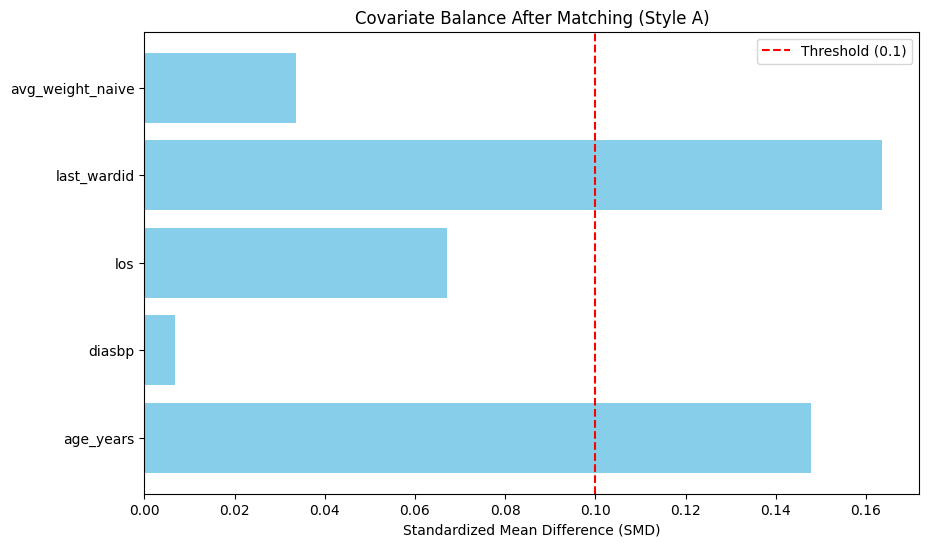

In [25]:
def calculate_smd(data, treatment_col, covariates):
    """Calculate Standardized Mean Differences for covariates."""
    treatment_group = data[data[treatment_col] == 1]
    control_group = data[data[treatment_col] == 0]

    smds = {}
    for cov in covariates:
        mean_treat = treatment_group[cov].mean()
        mean_control = control_group[cov].mean()
        pooled_std = np.sqrt(
            (treatment_group[cov].std()**2 + control_group[cov].std()**2) / 2
        )
        smd = (mean_treat - mean_control) / pooled_std
        smds[cov] = abs(smd)

    return smds

# Calculate SMD for Style A
covariates = ['age_years', 'diasbp', 'los', 'last_wardid', 'avg_weight_naive']  # Example covariates
smds_a = calculate_smd(matched_data_a, treatment_col='is_weekend_admission', covariates=covariates)

# Plot SMD
plt.figure(figsize=(10, 6))
plt.barh(list(smds_a.keys()), list(smds_a.values()), color='skyblue')
plt.axvline(0.1, color='red', linestyle='--', label='Threshold (0.1)')
plt.xlabel('Standardized Mean Difference (SMD)')
plt.title('Covariate Balance After Matching (Style A)')
plt.legend()
plt.show()




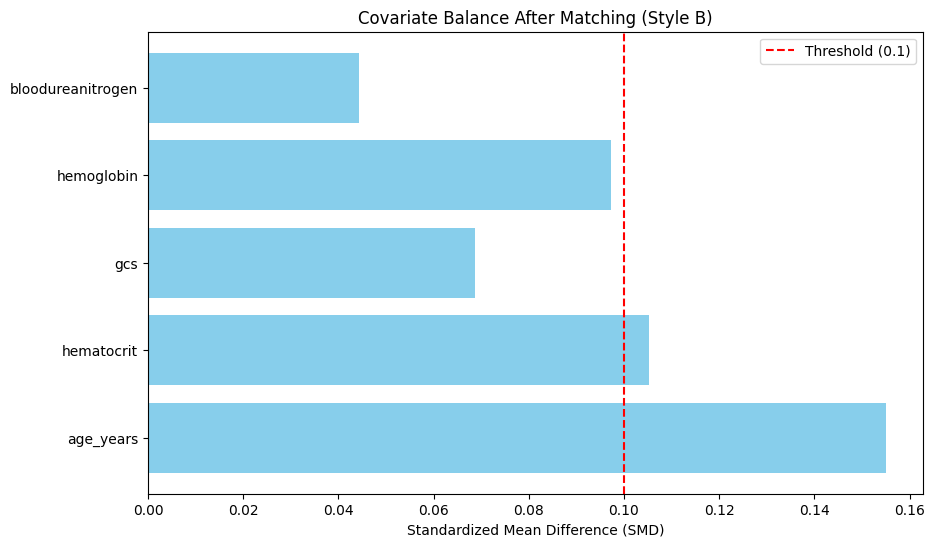

In [26]:
# Calculate SMD for Style B
covariates = ['age_years', 'hematocrit', 'gcs', 'hemoglobin', 'bloodureanitrogen']
smds_b = calculate_smd(matched_data_b, treatment_col='is_weekend_admission', covariates=covariates)

plt.figure(figsize=(10, 6))
plt.barh(list(smds_b.keys()), list(smds_b.values()), color='skyblue')
plt.axvline(0.1, color='red', linestyle='--', label='Threshold (0.1)')
plt.xlabel('Standardized Mean Difference (SMD)')
plt.title('Covariate Balance After Matching (Style B)')
plt.legend()
plt.show()

1. **Threshold for Balance**:
   - The red dashed line at \( \text{SMD} = 0.1 \) represents the commonly accepted threshold for considering a covariate as balanced.
   - Covariates with SMD below 0.1 are considered well-balanced between the groups (weekend vs. weekday admissions).

2. **Style A**:
   - Some covariates (e.g., `avg_weight_naive` and `diasbp`) show excellent balance with SMD values well below the 0.1 threshold.
   - Other covariates, like `last_wardid` and `age_years`, are slightly above the threshold, indicating residual imbalance that could influence the results.

3. **Style B**:
   - Covariates like `bloodureanitrogen` and `hemoglobin` exhibit good balance with SMD values below 0.1.
   - `age_years` and `hematocrit` exceed the threshold, suggesting that these variables may still have some imbalance even after matching.